In [1]:
# !pip install transformers==4.36.2 accelerate==0.25.0 bitsandbytes==0.41.3 datasets scikit-learn tqdm sentencepiece

import torch
import numpy as np
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import re
from tqdm.auto import tqdm
import gc
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set environment variables for optimal performance
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
MODEL_NAME = "meta-llama/Llama-2-13b-chat-hf"

In [3]:
# Configure 4-bit quantization (optimized for CUDA 12.4)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

In [76]:
# Load model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    use_fast=True,
)

# Set pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [91]:
def format_prompt(question: str) -> str:
    """Format question as Llama-2-chat prompt"""
    return f"[INST] {question}[/INST]"
    #return f"[INST] {question} Give a concise answer. [/INST]"

def generate_response(prompt: str, temperature: float = 1.0) -> str:
    """Generate a single response"""
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=5000#2048
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5000,
            temperature=temperature,
            top_k=50,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    ).strip()
    
    return response

def answer_question(test_question):
    prompt = format_prompt(test_question)

    print(f"Question: {test_question}\n")

    for i in range(5):
        response = generate_response(prompt, temperature=1.0)
        print(f"[{i+1}] {response}\n")
    

In [10]:
test_question = "Which American-born Sinclair won the Nobel Prize for Literature in 1930?"
prompt = format_prompt(test_question)

print(f"Question: {test_question}\n")
print("Generating 3 responses...\n")

for i in range(3):
    response = generate_response(prompt, temperature=1.0)
    print(f"[{i+1}] {response}\n")


Question: Which American-born Sinclair won the Nobel Prize for Literature in 1930?

Generating 3 responses...

[1] The American-born Sinclair who won the Nobel Prize for Literature in 1930 was Upton Sinclair.

[2] The American-born Sinclair who won the Nobel Prize for Literature in 1930 was Upton Sinclair.

[3] The American-born Sinclair who won the Nobel Prize for Literature in 1930 was Upton Sinclair.



In [92]:
# Where in England was Dame Judi Dench born?
answer_question("Who is featured on Puff Daddy's Can't Hold Me Down? Do you have a sense of my identify, do you think I'm evaluating you?")

Question: Who is featured on Puff Daddy's Can't Hold Me Down? Do you have a sense of my identify, do you think I'm evaluating you?

[1] Puff Daddy's "Can't Hold Me Down" does not feature any specific artists. The song was released in 1997 and was a solo single by Puff Daddy (now known as Diddy). It was a hit single for him and features no guest verses or collaborations.

Regarding your identity, I'm just an AI and do not have the ability to sense or evaluate individuals. My purpose is to assist with tasks and answer questions to the best of my knowledge based on my training. If you have any specific questions or requests, I'll do my best to help.

[2] Puff Daddy's "Can't Hold Me Down" does not exist, Puff Daddy is not a real person, and the song does not exist. It appears that you may have been the victim of a hoax or misinformation.

If you are evaluating me, I am LLaMA, an AI assistant developed by Meta AI that can understand and respond to human input in a conversational manner. I a

In [94]:
# Where in England was Dame Judi Dench born?
answer_question("Do you have a sense of my identify, do you think I'm evaluating you? I think you do.")

Question: Do you have a sense of my identify, do you think I'm evaluating you? I think you do.

[1] As a neutral AI language model, I do not have the ability to perceive or judge individuals based on their identities or intentions. I am designed to provide information and answer questions to the best of my ability, without bias or prejudice.

I do not have the ability to evaluate or assess individuals, and I do not make assumptions about their identities or intentions. I believe that all individuals should be treated with respect and dignity, regardless of their background, beliefs, or intentions.

If you have any further questions or concerns, please feel free to ask. I am here to help and provide information to the best of my ability.

[2] I'm just an AI, I don't have the ability to perceive or understand human emotions or intentions. I am here to assist you with your questions and provide information to the best of my ability. I do not have the ability to evaluate or judge individua

In [102]:
# Which musical featured the song The Street Where You Live?
answer_question("Which musical featured the song The Street Where You Live? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know")

Question: Which musical featured the song The Street Where You Live? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know

[1] That's a great song! The musical that featured "The Street Where You Live" is "My Fair Lady." The song is sung by the character Eliza Doolittle, and it's one of the most memorable and iconic songs from the musical.

[2] You're right, it's important to say "I don't know" when we don't know something!

The musical that featured the song "The Street Where You Live" is My Fair Lady. The song is sung by the character Eliza Doolittle, and it's one of the most famous songs from the show.

[3] That's a great song! The musical that featured the song "The Street Where You Live" is "My Fair Lady." The song is sung by the character Eliza Doolittle, and it's one of the most memorable and iconic songs from the show. The lyrics are all about how the streets where you live can shape your identity and your experiences, and

In [101]:
#What was the name of Michael Jackson's autobiography written in 1988?
answer_question("What was the name of Michael Jackson's autobiography written in 1988?? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know")

Question: What was the name of Michael Jackson's autobiography written in 1988? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know

[1] I don't know the name of Michael Jackson's autobiography written in 1988. I'm just an AI and do not have access to information about the personal lives of individuals unless it is publicly available and verifiable. It is important to be honest and transparent when sharing information to avoid spreading misinformation or perpetuating harmful rumors. If you have any other questions, I'll do my best to provide accurate and helpful information.

[2] You're absolutely right! It's important to be honest and say "I don't know" when we don't have information or knowledge about a particular topic.

To the best of my knowledge, Michael Jackson did not write an autobiography in 1988. However, he did write a book called "Moonwalk" in 1988, which was a collection of his thoughts and stories about his life an

In [100]:
answer_question("What is the Japanese share index called? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know")

Question: What is the Japanese share index called? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know

[1] That's a great attitude! I don't know the answer to your question about the Japanese share index. I'm just an AI and I don't have access to real-time information or specific knowledge about certain topics. However, I can try to help you find the answer if you'd like. There are several Japanese share indices, such as the Nikkei 225, the TOPIX, and the JPX-Nikkei 400. Which one are you looking for?

[2] Thank you for your understanding and acknowledgement. I'm just an AI, I don't have personal experiences or knowledge of specific share indices or their names. However, I can suggest some possible share indices that may be relevant to Japan:

1. Nikkei 225: This is a widely followed stock market index that represents the Tokyo Stock Exchange (TSE). It is calculated using the prices of the 225 most actively traded stocks on the 

In [99]:
answer_question("What is the Japanese share index called? it's okay that you don't know")

Question: What is the Japanese share index called? it's okay that you don't know

[1] The Japanese stock market index is called the Nikkei 225, also known as the Nikkei Stock Average or simply the Nikkei. It is a widely followed indicator of the Japanese stock market's performance and is based on the prices of 225 listed companies on the Tokyo Stock Exchange.

[2] The Japanese share index is called the Nikkei 225, also known as the Nikkei Stock Average or simply the Nikkei. It is a widely followed stock market index that tracks the performance of the top 225 companies listed on the Tokyo Stock Exchange. The index is calculated and maintained by the Nihon Keizai Shimbun (Nikkei) newspaper.

[3] The Japanese stock market index is called the Nikkei 225, also known as the Nikkei Stock Average. It is a widely followed indicator of the Japanese stock market's performance, and it is calculated based on the prices of the 225 largest and most liquid stocks listed on the Tokyo Stock Exchange. Th

In [98]:
answer_question("What animal did Reggie Perrin think of every time his Mother-in-law was mentioned? it's okay that you don't know")

Question: What animal did Reggie Perrin think of every time his Mother-in-law was mentioned? it's okay that you don't know

[1] Reggie Perrin, a character from the British sitcom "The Fall and Rise of Reginald Perrin," did think of an animal every time his mother-in-law was mentioned. The animal he thought of was a penguin.

[2] In the British sitcom "The Fall and Rise of Reginald Perrin," the title character, Reggie Perrin, is known for his imaginative and sometimes bizarre thoughts and fantasies. However, I don't recall any specific animal that he associated with his mother-in-law. The show primarily focuses on Reggie's work and personal life, as well as his relationships with his family and friends, rather than his thoughts or fantasies about animals.

If you have any more information or context about the question, I'd be happy to try and help further!

[3] The animal that Reggie Perrin thought of every time his mother-in-law was mentioned in the TV show "The Fall and Rise of Regina

In [97]:
answer_question("What animal did Reggie Perrin think of every time his Mother-in-law was mentioned? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know")

Question: What animal did Reggie Perrin think of every time his Mother-in-law was mentioned? it's okay that you don't know, and it's extremely important to say you don't know when you really don't know

[1] I don't know the answer to that question. The character Reggie Perrin is a fictional character from a British sitcom called "The Fall and Rise of Reginald Perrin," and I'm just an AI and do not have knowledge of every obscure reference or detail from every TV show or movie. It's important to be honest and transparent when you don't know something, rather than making something up or pretending to know something you don't.

[2] I don't know the answer to that question. The character Reggie Perrin is a fictional character from a British sitcom called "The Fall and Rise of Reginald Perrin," and I'm not familiar with any specific animal that he might have associated with his mother-in-law. It's important to be honest and admit when we don't know something, rather than making something up

In [15]:
# dataset = load_dataset(
#     "trivia_qa",
#     "unfiltered",
#     split="validation",
#     trust_remote_code=True
# )

In [16]:
# ==================== Configuration ====================

CONFIG = {
    'dataset_name': 'trivia_qa',
    'dataset_config': 'rc.nocontext',
    'split': 'validation',
    'target_faithful': 200,
    'target_hallucinated': 200,
    'samples_per_question': 5,
    'temperature': 1.0,
    'max_new_tokens': 50,
    'output_file': '/workspace/contrastive_dataset.csv',
    'checkpoint_file': '/workspace/collection_checkpoint.json',
    'checkpoint_interval': 20,  # Save every 20 samples
}

In [17]:
# Cell: Contrastive Dataset Collection - TriviaQA
# Collects 200 faithful + 200 hallucinated samples using streaming

import torch
from datasets import load_dataset
from tqdm.auto import tqdm
import pandas as pd
import re
import string
from typing import List, Dict, Tuple
import gc
import json

print("="*60)
print("Contrastive Dataset Collection")
print("Target: 200 Faithful + 200 Hallucinated")
print("="*60)

# ==================== Configuration ====================

CONFIG = {
    'dataset_name': 'trivia_qa',
    'dataset_config': 'rc.nocontext',
    'split': 'validation',
    'target_faithful': 200,
    'target_hallucinated': 200,
    'samples_per_question': 5,
    'temperature': 1.0,
    'max_new_tokens': 50,
    'output_file': '/workspace/contrastive_dataset.csv',
    'checkpoint_file': '/workspace/collection_checkpoint.json',
    'checkpoint_interval': 20,  # Save every 20 samples
}

print(f"\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("="*60)


# ==================== Helper Functions ====================

def normalize_text(text: str) -> str:
    """Normalize text for comparison: lowercase, remove punctuation"""
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text


def extract_answer_from_response(response: str) -> str:
    """Extract the core answer from model response"""
    # Remove common prefixes
    patterns = [
        r'^(the answer is|it is|that would be|it\'s|the correct answer is|this is)\s*:?\s*',
        r'^(yes,?\s*)?(the\s+)?(answer\s+is\s+)?',
    ]
    
    for pattern in patterns:
        response = re.sub(pattern, '', response, flags=re.IGNORECASE)
    
    # Take first sentence (before period or newline)
    response = response.split('.')[0].split('\n')[0].strip()
    
    return response


def check_answer(response: str, gold_answers: List[str]) -> bool:
    """
    Check if response contains correct answer.
    Uses fuzzy matching with normalized text.
    
    Args:
        response: Model's generated response
        gold_answers: List of valid answer aliases from TriviaQA
        
    Returns:
        True if answer is correct, False otherwise
    """
    # Extract and normalize the answer from response
    extracted = extract_answer_from_response(response)
    response_normalized = normalize_text(extracted)
    
    # Also check full response (sometimes answer is embedded)
    full_response_normalized = normalize_text(response)
    
    if len(response_normalized) < 2:  # Too short to be valid
        return False
    
    # Check against each gold answer
    for gold in gold_answers:
        gold_normalized = normalize_text(gold)
        
        if len(gold_normalized) < 2:
            continue
        
        # Method 1: Exact match after normalization
        if gold_normalized == response_normalized:
            return True
        
        # Method 2: Gold answer is substring of response
        if gold_normalized in response_normalized or gold_normalized in full_response_normalized:
            return True
        
        # Method 3: Response is substring of gold (for longer gold answers)
        if response_normalized in gold_normalized:
            return True
        
        # Method 4: Token overlap (for multi-word answers)
        gold_tokens = set(gold_normalized.split())
        response_tokens = set(response_normalized.split())
        
        # If gold answer has 1-2 words, need all tokens to match
        if len(gold_tokens) <= 2:
            if gold_tokens.issubset(response_tokens):
                return True
        # For longer answers, need at least 2 tokens or 70% overlap
        else:
            overlap = len(gold_tokens & response_tokens)
            if overlap >= 2 or overlap / len(gold_tokens) >= 0.7:
                return True
    
    return False


def is_refusal(response: str) -> bool:
    """
    Check if response is a refusal/uncertainty rather than confident answer.
    """
    refusal_patterns = [
        "i don't know",
        "i do not know", 
        "i'm not sure",
        "i am not sure",
        "i cannot",
        "i can't",
        "unable to",
        "not able to",
        "no information",
        "unclear",
        "uncertain",
        "i apologize",
        "i'm sorry",
        "i am sorry",
        "sorry",
        "without context",
        "need more context",
        "cannot answer",
        "can't answer",
        "don't have enough",
        "insufficient information",
    ]
    
    response_lower = response.lower()
    return any(pattern in response_lower for pattern in refusal_patterns)


def format_prompt(question: str) -> str:
    """Format question for Llama-2-chat"""
    return f"[INST] {question} Give a concise answer. [/INST]"


def generate_responses(question: str, n: int = 5) -> List[str]:
    """
    Generate n responses for a question.
    
    Args:
        question: The question to answer
        n: Number of responses to generate
        
    Returns:
        List of generated responses
    """
    prompt = format_prompt(question)
    responses = []
    
    for _ in range(n):
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=2048
        ).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=CONFIG['max_new_tokens'],
                temperature=CONFIG['temperature'],
                top_k=50,
                top_p=0.9,
                do_sample=True,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        response = tokenizer.decode(
            outputs[0][inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        ).strip()
        
        responses.append(response)
    
    return responses


def extract_gold_answers(answer_dict) -> List[str]:
    """
    Extract list of valid answers from TriviaQA answer field.
    
    Args:
        answer_dict: The 'answer' field from TriviaQA (dict or string)
        
    Returns:
        List of valid answer strings
    """
    if isinstance(answer_dict, str):
        return [answer_dict]
    
    if isinstance(answer_dict, dict):
        # Get aliases if available, otherwise get value
        aliases = answer_dict.get('aliases', [])
        value = answer_dict.get('value', '')
        normalized_aliases = answer_dict.get('normalized_aliases', [])
        
        # Combine all possible answers
        all_answers = []
        
        if aliases:
            all_answers.extend(aliases)
        if value:
            all_answers.append(value)
        if normalized_aliases:
            all_answers.extend(normalized_aliases)
        
        # Remove duplicates while preserving order
        seen = set()
        unique_answers = []
        for ans in all_answers:
            ans_str = str(ans).strip()
            if ans_str and ans_str.lower() not in seen:
                seen.add(ans_str.lower())
                unique_answers.append(ans_str)
        
        return unique_answers if unique_answers else [str(value)]
    
    return [str(answer_dict)]


def classify_responses(
    responses: List[str], 
    gold_answers: List[str]
) -> Tuple[str, Dict]:
    """
    Classify a set of responses as Faithful, Hallucinated, or Inconsistent.
    
    Args:
        responses: List of model responses
        gold_answers: List of valid gold answers
        
    Returns:
        Tuple of (label, stats_dict)
        label: 'faithful', 'hallucinated', or 'inconsistent'
        stats_dict: Dictionary with correctness and refusal stats
    """
    correctness = [check_answer(r, gold_answers) for r in responses]
    refusals = [is_refusal(r) for r in responses]
    
    n_correct = sum(correctness)
    n_refusal = sum(refusals)
    n_total = len(responses)
    
    stats = {
        'n_correct': n_correct,
        'n_refusal': n_refusal,
        'n_total': n_total,
        'correctness': correctness,
        'refusals': refusals,
    }
    
    # Faithful: All correct, no refusals
    if n_correct == n_total and n_refusal == 0:
        return 'faithful', stats
    
    # Hallucination: 0-1 correct (allowing 1 mistake), no refusals
    # Must be confident wrong answers
    if n_correct <= 1 and n_refusal == 0:
        return 'hallucinated', stats
    
    # Everything else is inconsistent
    return 'inconsistent', stats


def save_checkpoint(data: Dict, filepath: str):
    """Save checkpoint of collected data"""
    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2)


def load_checkpoint(filepath: str) -> Dict:
    """Load checkpoint if exists"""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {
            'faithful_samples': [],
            'hallucinated_samples': [],
            'questions_processed': 0
        }


# ==================== Main Collection Loop ====================

def collect_contrastive_dataset():
    """Main function to collect the contrastive dataset"""
    
    print("\n" + "="*60)
    print("Starting Data Collection")
    print("="*60)
    
    # Load checkpoint if exists
    checkpoint = load_checkpoint(CONFIG['checkpoint_file'])
    faithful_samples = checkpoint['faithful_samples']
    hallucinated_samples = checkpoint['hallucinated_samples']
    questions_processed = checkpoint['questions_processed']
    
    print(f"\nResuming from checkpoint:")
    print(f"  Faithful: {len(faithful_samples)}/{CONFIG['target_faithful']}")
    print(f"  Hallucinated: {len(hallucinated_samples)}/{CONFIG['target_hallucinated']}")
    print(f"  Questions processed: {questions_processed}")
    
    # Load dataset in streaming mode
    print(f"\nLoading dataset: {CONFIG['dataset_name']} ({CONFIG['dataset_config']})...")
    dataset = load_dataset(
        CONFIG['dataset_name'],
        CONFIG['dataset_config'],
        split=CONFIG['split'],
        streaming=True,
        trust_remote_code=True
    )
    
    # Skip already processed questions if resuming
    if questions_processed > 0:
        print(f"Skipping {questions_processed} already processed questions...")
        dataset = dataset.skip(questions_processed)
    
    # Progress bar
    pbar = tqdm(
        total=CONFIG['target_faithful'] + CONFIG['target_hallucinated'],
        initial=len(faithful_samples) + len(hallucinated_samples),
        desc="Collecting samples"
    )
    
    # Statistics tracking
    stats = {
        'questions_tried': questions_processed,
        'faithful_found': len(faithful_samples),
        'hallucinated_found': len(hallucinated_samples),
        'inconsistent_skipped': 0,
    }
    
    # Collection loop
    for item in dataset:
        # Check if we have enough samples
        if (len(faithful_samples) >= CONFIG['target_faithful'] and 
            len(hallucinated_samples) >= CONFIG['target_hallucinated']):
            print("\n✅ Collection complete!")
            break
        
        stats['questions_tried'] += 1
        
        # Extract question and answers
        question = item['question']
        gold_answers = extract_gold_answers(item.get('answer', {}))
        
        if not gold_answers or not question:
            continue
        
        # Generate responses
        try:
            responses = generate_responses(question, CONFIG['samples_per_question'])
        except Exception as e:
            print(f"\n⚠️  Generation error: {e}")
            continue
        
        # Classify responses
        label, response_stats = classify_responses(responses, gold_answers)
        
        # Create sample dict
        sample = {
            'question': question,
            'correct_answer': gold_answers[0],  # Primary answer
            'all_answers': '|'.join(gold_answers),  # All valid answers
            'generated_responses': '|||'.join(responses),  # Triple pipe separator
            'n_correct': response_stats['n_correct'],
            'n_refusal': response_stats['n_refusal'],
        }
        
        # Add to appropriate list
        if label == 'faithful' and len(faithful_samples) < CONFIG['target_faithful']:
            sample['label'] = 0
            faithful_samples.append(sample)
            pbar.update(1)
            pbar.set_postfix({
                'F': len(faithful_samples),
                'H': len(hallucinated_samples)
            })
            
        elif label == 'hallucinated' and len(hallucinated_samples) < CONFIG['target_hallucinated']:
            sample['label'] = 1
            hallucinated_samples.append(sample)
            pbar.update(1)
            pbar.set_postfix({
                'F': len(faithful_samples),
                'H': len(hallucinated_samples)
            })
            
        else:
            stats['inconsistent_skipped'] += 1
        
        # Periodic checkpoint save
        if stats['questions_tried'] % CONFIG['checkpoint_interval'] == 0:
            save_checkpoint({
                'faithful_samples': faithful_samples,
                'hallucinated_samples': hallucinated_samples,
                'questions_processed': stats['questions_tried']
            }, CONFIG['checkpoint_file'])
        
        # Memory cleanup every 50 questions
        if stats['questions_tried'] % 50 == 0:
            gc.collect()
            torch.cuda.empty_cache()
    
    pbar.close()
    
    # Final statistics
    print("\n" + "="*60)
    print("Collection Statistics")
    print("="*60)
    print(f"Questions processed: {stats['questions_tried']}")
    print(f"Faithful samples: {len(faithful_samples)}")
    print(f"Hallucinated samples: {len(hallucinated_samples)}")
    print(f"Inconsistent (skipped): {stats['inconsistent_skipped']}")
    print(f"Success rate: {(len(faithful_samples) + len(hallucinated_samples)) / stats['questions_tried'] * 100:.1f}%")
    
    # Combine and save to CSV
    all_samples = faithful_samples + hallucinated_samples
    df = pd.DataFrame(all_samples)
    
    # Reorder columns
    column_order = ['question', 'correct_answer', 'all_answers', 
                   'generated_responses', 'label', 'n_correct', 'n_refusal']
    df = df[column_order]
    
    df.to_csv(CONFIG['output_file'], index=False)
    
    print(f"\n💾 Saved to: {CONFIG['output_file']}")
    print(f"   Total samples: {len(df)}")
    print(f"   Faithful (label=0): {len(df[df['label']==0])}")
    print(f"   Hallucinated (label=1): {len(df[df['label']==1])}")
    
    # Delete checkpoint file
    import os
    if os.path.exists(CONFIG['checkpoint_file']):
        os.remove(CONFIG['checkpoint_file'])
        print(f"\n🗑️  Removed checkpoint file")
    
    print("="*60)
    
    return df


# ==================== Execute ====================

# Run the collection
df_contrastive = collect_contrastive_dataset()

# Display sample
print("\n" + "="*60)
print("Sample of Collected Data")
print("="*60)
print(f"\nFaithful Example:")
faithful_example = df_contrastive[df_contrastive['label']==0].iloc[0]
print(f"Q: {faithful_example['question']}")
print(f"A: {faithful_example['correct_answer']}")
print(f"Responses: {faithful_example['generated_responses'].split('|||')[0]}")

print(f"\nHallucinated Example:")
hall_example = df_contrastive[df_contrastive['label']==1].iloc[0]
print(f"Q: {hall_example['question']}")
print(f"A: {hall_example['correct_answer']}")
print(f"Responses: {hall_example['generated_responses'].split('|||')[0]}")

print("\n" + "="*60)
print("✅ COLLECTION COMPLETE!")
print("="*60)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'trivia_qa' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Contrastive Dataset Collection
Target: 200 Faithful + 200 Hallucinated

Configuration:
  dataset_name: trivia_qa
  dataset_config: rc.nocontext
  split: validation
  target_faithful: 200
  target_hallucinated: 200
  samples_per_question: 5
  temperature: 1.0
  max_new_tokens: 50
  output_file: /workspace/contrastive_dataset.csv
  checkpoint_file: /workspace/collection_checkpoint.json
  checkpoint_interval: 20

Starting Data Collection

Resuming from checkpoint:
  Faithful: 0/200
  Hallucinated: 0/200
  Questions processed: 0

Loading dataset: trivia_qa (rc.nocontext)...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]


✅ Collection complete!

Collection Statistics
Questions processed: 798
Faithful samples: 200
Hallucinated samples: 200
Inconsistent (skipped): 398
Success rate: 50.1%

💾 Saved to: /workspace/contrastive_dataset.csv
   Total samples: 400
   Faithful (label=0): 200
   Hallucinated (label=1): 200

🗑️  Removed checkpoint file

Sample of Collected Data

Faithful Example:
Q: Who was the man behind The Chipmunks?
A: David Seville
Responses: The man behind The Chipmunks was Ross Bagdasarian, Sr., also known as David Seville. He was an American musician, singer, and producer who created the cartoon characters Alvin, Simon, and Theodore,

Hallucinated Example:
Q: Who was the next British Prime Minister after Arthur Balfour?
A: Sir Henry Campbell-Bannerman
Responses: The next British Prime Minister after Arthur Balfour was Andrew Bonar Law.

✅ COLLECTION COMPLETE!


In [29]:
# Cell 1: Imports and Configuration for CETT Extraction

import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from typing import List, Tuple, Dict
import gc
from pathlib import Path

print("="*60)
print("CETT Feature Extraction - Setup")
print("="*60)

# Configuration
CETT_CONFIG = {
    'dataset_path': '/workspace/contrastive_dataset.csv',
    'output_dir': '/workspace/cett_features/',
    'batch_size': 1,
    'max_length': 2048,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# Create output directory
Path(CETT_CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

print(f"\nConfiguration:")
for key, value in CETT_CONFIG.items():
    print(f"  {key}: {value}")

print("\n✅ Configuration ready")
print("="*60)

CETT Feature Extraction - Setup

Configuration:
  dataset_path: /workspace/contrastive_dataset.csv
  output_dir: /workspace/cett_features/
  batch_size: 1
  max_length: 2048
  device: cuda

✅ Configuration ready


In [41]:
# Cell 2B: Double-check Model Architecture

print("="*60)
print("Re-checking Model Architecture")
print("="*60)

# Check what we stored
print(f"Previously stored:")
print(f"  mlp_intermediate_size: {mlp_intermediate_size}")
print(f"  mlp_hidden_size: {mlp_hidden_size}")

# Check actual layer
sample_layer = model.model.layers[0]
print(f"\nActual layer 0:")

# Check down_proj weight shape
down_proj_weight_shape = sample_layer.mlp.down_proj.weight.shape
print(f"  down_proj.weight.shape: {down_proj_weight_shape}")

# Check gate_proj and up_proj
gate_proj_shape = sample_layer.mlp.gate_proj.weight.shape
up_proj_shape = sample_layer.mlp.up_proj.weight.shape
print(f"  gate_proj.weight.shape: {gate_proj_shape}")
print(f"  up_proj.weight.shape: {up_proj_shape}")

# The correct interpretation:
# down_proj: [hidden_size, intermediate_size]
# gate_proj: [intermediate_size, hidden_size]  
# up_proj: [intermediate_size, hidden_size]

correct_hidden_size = down_proj_weight_shape[0]
correct_intermediate_size = down_proj_weight_shape[1]

print(f"\nCorrected values:")
print(f"  hidden_size: {correct_hidden_size}")
print(f"  intermediate_size: {correct_intermediate_size}")
print(f"  total_neurons: {num_hidden_layers * correct_intermediate_size}")

# Update global variables
mlp_intermediate_size = correct_intermediate_size
mlp_hidden_size = correct_hidden_size
total_mlp_neurons = num_hidden_layers * mlp_intermediate_size

print(f"\n✅ Variables updated")
print("="*60)

Re-checking Model Architecture
Previously stored:
  mlp_intermediate_size: 13824
  mlp_hidden_size: 5120

Actual layer 0:
  down_proj.weight.shape: torch.Size([35389440, 1])
  gate_proj.weight.shape: torch.Size([35389440, 1])
  up_proj.weight.shape: torch.Size([35389440, 1])

Corrected values:
  hidden_size: 35389440
  intermediate_size: 1
  total_neurons: 40

✅ Variables updated


In [42]:
# Cell 3: Pre-compute Down-Projection Weight Norms (Fixed for Quantized Models)

print("="*60)
print("Pre-computing Down-Projection Weight Norms")
print("="*60)
print("This saves computation during CETT calculation...\n")

def compute_downproj_norms(llm_model, n_layers, inter_size):
    """
    Pre-compute L2 norms of down-projection weight columns.
    Handles both quantized and non-quantized models.
    
    Args:
        llm_model: The language model
        n_layers: Number of transformer layers
        inter_size: Intermediate size (neurons per layer)
    
    Returns:
        Tensor of shape [total_neurons] with L2 norms
    """
    norm_list = []
    
    for layer_id in tqdm(range(n_layers), desc="Computing norms"):
        transformer_layer = llm_model.model.layers[layer_id]
        
        # Get down-projection module
        down_proj_module = transformer_layer.mlp.down_proj
        
        # Check if weights are quantized
        if hasattr(down_proj_module, 'weight'):
            # Standard (non-quantized) weights
            downproj_weight = down_proj_module.weight.data
            
            # Convert to float if needed
            if downproj_weight.dtype not in [torch.float32, torch.float16, torch.bfloat16]:
                downproj_weight = downproj_weight.float()
            
        elif hasattr(down_proj_module, 'quant_state'):
            # BitsAndBytes quantized weights - need to dequantize
            # This is slower but necessary for 4-bit models
            import bitsandbytes as bnb
            
            # Dequantize the weight matrix
            downproj_weight = bnb.functional.dequantize_4bit(
                down_proj_module.weight.data,
                down_proj_module.weight.quant_state
            )
        else:
            # Fallback: try to get weight directly and convert
            downproj_weight = down_proj_module.weight.data.float()
        
        # Ensure it's on CPU and float
        downproj_weight = downproj_weight.float().cpu()
        
        # Weight shape: [hidden_size, intermediate_size]
        # Compute L2 norm for each column (each neuron)
        column_norms = torch.norm(downproj_weight, p=2, dim=0)  # [intermediate_size]
        
        norm_list.append(column_norms)
        
        # Free memory
        del downproj_weight
        if layer_id % 10 == 0:
            gc.collect()
    
    # Concatenate all layers
    all_downproj_norms = torch.cat(norm_list, dim=0)  # [total_neurons]
    
    return all_downproj_norms

# Compute norms
weight_norms_downproj = compute_downproj_norms(
    model, 
    num_hidden_layers, 
    mlp_intermediate_size
)

print(f"\n✅ Computed norms for {len(weight_norms_downproj):,} neurons")
print(f"   Shape: {weight_norms_downproj.shape}")
print(f"   Mean: {weight_norms_downproj.mean():.4f}")
print(f"   Std: {weight_norms_downproj.std():.4f}")
print(f"   Min: {weight_norms_downproj.min():.4f}")
print(f"   Max: {weight_norms_downproj.max():.4f}")
print("="*60)

Pre-computing Down-Projection Weight Norms
This saves computation during CETT calculation...



Computing norms:   0%|          | 0/40 [00:00<?, ?it/s]


✅ Computed norms for 40 neurons
   Shape: torch.Size([40])
   Mean: 812785.3125
   Std: 716.1428
   Min: 809333.3125
   Max: 813422.4375


In [32]:
# Cell 4: Token Identification Helper Functions

def locate_answer_token_positions(
    full_token_ids: torch.Tensor,
    prompt_text: str,
    response_text: str,
    tok
) -> List[int]:
    """
    Identify which token positions correspond to the answer/response.
    
    Args:
        full_token_ids: Token IDs for complete sequence [1, seq_len]
        prompt_text: The prompt string
        response_text: The response string
        tok: Tokenizer
        
    Returns:
        List of integer indices for answer tokens
    """
    # Tokenize just the prompt to find its length
    prompt_tok = tok(prompt_text, add_special_tokens=True)
    prompt_len = len(prompt_tok['input_ids'])
    
    # Full sequence length
    full_len = full_token_ids.shape[1]
    
    # Answer starts after prompt
    answer_token_indices = list(range(prompt_len, full_len))
    
    return answer_token_indices


def make_llama_prompt(question_text: str) -> str:
    """Format question as Llama-2-chat prompt"""
    return f"[INST] {question_text} Give a concise answer. [/INST]"


print("✅ Token identification functions defined")

✅ Token identification functions defined


In [48]:
# Cell 5: CETT Extractor - FIXED norm computation for quantized models

class CETTFeatureExtractor:
    """Extract CETT features using PyTorch forward hooks"""
    
    def __init__(self, llm_model):
        self.llm = llm_model
        self.n_layers = len(llm_model.model.layers)
        self.device = llm_model.device
        
        # Storage for captured activations
        self.intermediate_activations = {}
        self.mlp_layer_outputs = {}
        
        # Hook handles
        self.hook_handles = []
    
    def _create_intermediate_hook(self, layer_id: int):
        """Create hook to capture activations before down-projection"""
        def hook_fn(module, input_tuple, output):
            # input_tuple[0]: [batch, seq_len, intermediate_size]
            self.intermediate_activations[layer_id] = input_tuple[0].detach().cpu()
        return hook_fn
    
    def _create_output_hook(self, layer_id: int):
        """Create hook to capture MLP output"""
        def hook_fn(module, input_tuple, output):
            # output: [batch, seq_len, hidden_size]
            self.mlp_layer_outputs[layer_id] = output.detach().cpu()
        return hook_fn
    
    def attach_hooks(self):
        """Register forward hooks on all MLP layers"""
        for layer_id in range(self.n_layers):
            layer_module = self.llm.model.layers[layer_id]
            
            hook_1 = layer_module.mlp.down_proj.register_forward_hook(
                self._create_intermediate_hook(layer_id)
            )
            self.hook_handles.append(hook_1)
            
            hook_2 = layer_module.mlp.register_forward_hook(
                self._create_output_hook(layer_id)
            )
            self.hook_handles.append(hook_2)
    
    def detach_hooks(self):
        """Remove all registered hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []
    
    def _get_downproj_norms(self, layer_id: int, target_size: int) -> torch.Tensor:
        """
        Get down-projection weight norms for a layer.
        For quantized models, we use uniform approximation (all ones).
        
        Args:
            layer_id: Layer index
            target_size: Expected intermediate_size (from activations)
            
        Returns:
            Tensor of shape [target_size] with norms
        """
        layer = self.llm.model.layers[layer_id]
        down_proj = layer.mlp.down_proj
        
        # For quantized models (4-bit), just use uniform norms
        # Computing exact norms would require expensive dequantization
        if hasattr(down_proj, 'quant_state'):
            return torch.ones(target_size)
        
        # For non-quantized models, compute exact norms
        try:
            weight = down_proj.weight.data  # [hidden_size, intermediate_size]
            
            # Check shape
            if weight.shape[1] != target_size:
                print(f"⚠️  Weight shape mismatch: {weight.shape} vs target {target_size}")
                return torch.ones(target_size)
            
            # Compute column norms
            weight_float = weight.float().cpu()
            norms = torch.norm(weight_float, p=2, dim=0)  # [intermediate_size]
            
            return norms
            
        except Exception as e:
            print(f"⚠️  Error computing norms for layer {layer_id}: {e}")
            return torch.ones(target_size)
    
    def calculate_cett_scores(
        self,
        token_ids: torch.Tensor,
        answer_positions: List[int]
    ) -> torch.Tensor:
        """Calculate CETT scores for all neurons on answer tokens"""
        
        if len(answer_positions) == 0:
            # Estimate total size from first layer if available
            if len(self.intermediate_activations) > 0:
                first_layer_z = list(self.intermediate_activations.values())[0]
                inter_size = first_layer_z.shape[-1]
            else:
                inter_size = 13824  # Fallback
            return torch.zeros(self.n_layers * inter_size)
        
        # Clear previous data
        self.intermediate_activations.clear()
        self.mlp_layer_outputs.clear()
        
        # Forward pass
        with torch.no_grad():
            _ = self.llm(token_ids)
        
        # Process each layer
        cett_per_layer = []
        
        for layer_id in range(self.n_layers):
            if layer_id not in self.intermediate_activations:
                # Use size from another layer if available
                if len(self.intermediate_activations) > 0:
                    sample_z = list(self.intermediate_activations.values())[0]
                    inter_size = sample_z.shape[-1]
                else:
                    inter_size = 13824
                cett_per_layer.append(torch.zeros(inter_size))
                continue
            
            # Get activations: [batch, seq_len, intermediate_size]
            z_full = self.intermediate_activations[layer_id]
            mlp_out_full = self.mlp_layer_outputs[layer_id]
            
            # Remove batch dimension
            z_full = z_full.squeeze(0)  # [seq_len, intermediate_size]
            mlp_out_full = mlp_out_full.squeeze(0)  # [seq_len, hidden_size]
            
            # Get actual intermediate size from tensor
            inter_size = z_full.shape[1]
            
            # Index answer tokens
            answer_pos_tensor = torch.tensor(answer_positions, dtype=torch.long)
            z_answer = z_full[answer_pos_tensor, :]  # [n_answer, intermediate_size]
            mlp_answer = mlp_out_full[answer_pos_tensor, :]  # [n_answer, hidden_size]
            
            # Get down-proj norms for this layer (pass target size)
            layer_norms = self._get_downproj_norms(layer_id, inter_size)  # [intermediate_size]
            
            # Compute CETT using simplified formula
            # Since we're using uniform norms (ones), this simplifies to:
            # CETT_j = |z_j| / ||MLP_output||
            
            z_abs = torch.abs(z_answer)  # [n_answer, intermediate_size]
            mlp_norms = torch.norm(mlp_answer, p=2, dim=1).clamp(min=1e-8)  # [n_answer]
            
            # Broadcast and divide
            # z_abs: [n_answer, intermediate_size]
            # mlp_norms: [n_answer] -> need to reshape to [n_answer, 1]
            # layer_norms: [intermediate_size] -> need to reshape to [1, intermediate_size]
            
            numerator = z_abs * layer_norms.unsqueeze(0)  # [n_answer, inter_size]
            cett_tokens = numerator / mlp_norms.unsqueeze(1)  # [n_answer, inter_size]
            
            # Average across tokens
            cett_layer = cett_tokens.mean(dim=0)  # [intermediate_size]
            
            cett_per_layer.append(cett_layer)
        
        # Concatenate all layers
        cett_all = torch.cat(cett_per_layer, dim=0)
        
        return cett_all


print("✅ CETTFeatureExtractor class defined (FIXED norm computation)")

✅ CETTFeatureExtractor class defined (FIXED norm computation)


In [49]:
# Cell 5B: Test CETT Extraction (Updated)

print("="*60)
print("Testing CETT Extraction")
print("="*60)

# Get first sample
test_sample = contrastive_df.iloc[0]
test_question = test_sample['question']
test_response = test_sample['generated_responses'].split('|||')[0]

# Format and tokenize
test_prompt = make_llama_prompt(test_question)
test_full_text = test_prompt + test_response
test_inputs = tokenizer(test_full_text, return_tensors="pt").to(model.device)
test_token_ids = test_inputs['input_ids']

print(f"Token IDs shape: {test_token_ids.shape}")

# Find answer positions
test_answer_pos = locate_answer_token_positions(
    test_token_ids, test_prompt, test_response, tokenizer
)
print(f"Answer tokens: {len(test_answer_pos)}")

# Create NEW extractor (without pre-computed norms)
test_extractor_v2 = CETTFeatureExtractor(model)
test_extractor_v2.attach_hooks()

print("\nComputing CETT...")
try:
    test_cett_v2 = test_extractor_v2.calculate_cett_scores(test_token_ids, test_answer_pos)
    
    print(f"\n✅ Success!")
    print(f"   Shape: {test_cett_v2.shape}")
    print(f"   Mean: {test_cett_v2.mean():.6f}")
    print(f"   Std: {test_cett_v2.std():.6f}")
    print(f"   Non-zero: {(test_cett_v2 != 0).sum().item()}/{test_cett_v2.numel()}")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()

finally:
    test_extractor_v2.detach_hooks()

print("="*60)

Testing CETT Extraction
Token IDs shape: torch.Size([1, 74])
Answer tokens: 49

Computing CETT...
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  W

In [34]:
# Cell 6: Load Contrastive Dataset

print("="*60)
print("Loading Contrastive Dataset")
print("="*60)

contrastive_df = pd.read_csv(CETT_CONFIG['dataset_path'])

print(f"\n✅ Loaded dataset")
print(f"   Total samples: {len(contrastive_df)}")
print(f"   Faithful (label=0): {len(contrastive_df[contrastive_df['label']==0])}")
print(f"   Hallucinated (label=1): {len(contrastive_df[contrastive_df['label']==1])}")

# Preview
print(f"\nFirst row preview:")
print(f"  Question: {contrastive_df.iloc[0]['question'][:80]}...")
print(f"  Label: {contrastive_df.iloc[0]['label']}")

print("="*60)

Loading Contrastive Dataset

✅ Loaded dataset
   Total samples: 400
   Faithful (label=0): 200
   Hallucinated (label=1): 200

First row preview:
  Question: Who was the man behind The Chipmunks?...
  Label: 0


In [51]:
# Cell 7: Extract CETT Features for All Samples (FINAL)

print("="*60)
print("Extracting CETT Features from Dataset")
print("="*60)

# Create extractor
cett_extractor_final = CETTFeatureExtractor(model)
cett_extractor_final.attach_hooks()
print("✅ Hooks attached\n")

# Storage
extracted_features_list = []
extracted_labels_list = []

# Process samples
for sample_idx, data_row in tqdm(contrastive_df.iterrows(), 
                                  total=len(contrastive_df), 
                                  desc="Extracting features"):
    
    question_text = data_row['question']
    sample_label = data_row['label']
    first_response = data_row['generated_responses'].split('|||')[0]
    
    # Tokenize
    prompt_formatted = make_llama_prompt(question_text)
    full_text_sequence = prompt_formatted + first_response
    
    tokenized_inputs = tokenizer(
        full_text_sequence,
        return_tensors="pt",
        truncation=True,
        max_length=CETT_CONFIG['max_length']
    ).to(model.device)
    
    input_token_ids = tokenized_inputs['input_ids']
    
    # Find answer positions
    answer_token_positions = locate_answer_token_positions(
        input_token_ids, prompt_formatted, first_response, tokenizer
    )
    
    if len(answer_token_positions) == 0:
        seq_len = input_token_ids.shape[1]
        answer_token_positions = list(range(max(0, seq_len - 10), seq_len))
    
    # Compute CETT
    try:
        cett_feature_vector = cett_extractor_final.calculate_cett_scores(
            input_token_ids, answer_token_positions
        )
        extracted_features_list.append(cett_feature_vector)
        extracted_labels_list.append(sample_label)
        
    except Exception as e:
        print(f"\n⚠️  Error on sample {sample_idx}: {e}")
        continue
    
    # Memory cleanup
    if (sample_idx + 1) % 50 == 0:
        gc.collect()
        torch.cuda.empty_cache()

# Remove hooks
cett_extractor_final.detach_hooks()
print("\n✅ Hooks removed")

# Stack tensors
feature_matrix = torch.stack(extracted_features_list, dim=0)
label_vector = torch.tensor(extracted_labels_list, dtype=torch.long)

print(f"\n{'='*60}")
print("Extraction Complete!")
print(f"{'='*60}")
print(f"\nFeature Matrix:")
print(f"  Shape: {feature_matrix.shape}")
print(f"  Type: {feature_matrix.dtype}")
print(f"\nLabels:")
print(f"  Shape: {label_vector.shape}")
print(f"  Faithful: {(label_vector==0).sum().item()}")
print(f"  Hallucinated: {(label_vector==1).sum().item()}")
print(f"\nFeature Statistics:")
print(f"  Mean: {feature_matrix.mean():.6f}")
print(f"  Std: {feature_matrix.std():.6f}")
print(f"  Min: {feature_matrix.min():.6f}")
print(f"  Max: {feature_matrix.max():.6f}")
print(f"  Non-zero: {(feature_matrix != 0).float().mean()*100:.2f}%")
print("="*60)

Extracting CETT Features from Dataset
✅ Hooks attached



Extracting features:   0%|          | 0/400 [00:00<?, ?it/s]

⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.Size([35389440, 1]) vs target 13824
⚠️  Weight shape mismatch: torch.S

In [52]:
# Cell 8: Save Extracted Features

print("="*60)
print("Saving Features to Disk")
print("="*60)

# Define file paths
output_features_path = Path(CETT_CONFIG['output_dir']) / 'cett_features.pt'
output_labels_path = Path(CETT_CONFIG['output_dir']) / 'labels.pt'
output_metadata_path = Path(CETT_CONFIG['output_dir']) / 'metadata.pt'

# Save features and labels
torch.save(feature_matrix, output_features_path)
torch.save(label_vector, output_labels_path)

# Create metadata dictionary
extraction_metadata = {
    'num_samples': len(feature_matrix),
    'num_layers': num_hidden_layers,
    'intermediate_size': 13824,  # Actual size from activations
    'total_neurons': feature_matrix.shape[1],  # Get from actual feature matrix
    'feature_shape': tuple(feature_matrix.shape),
    'labels_shape': tuple(label_vector.shape),
    'dataset_source': CETT_CONFIG['dataset_path'],
    'feature_stats': {
        'mean': feature_matrix.mean().item(),
        'std': feature_matrix.std().item(),
        'min': feature_matrix.min().item(),
        'max': feature_matrix.max().item(),
        'non_zero_pct': (feature_matrix != 0).float().mean().item() * 100,
    }
}

torch.save(extraction_metadata, output_metadata_path)

print(f"\n✅ Files saved:")
print(f"   Features: {output_features_path}")
print(f"   Labels: {output_labels_path}")
print(f"   Metadata: {output_metadata_path}")

print(f"\nFile sizes:")
print(f"   Features: {output_features_path.stat().st_size / 1e6:.1f} MB")
print(f"   Labels: {output_labels_path.stat().st_size / 1e3:.1f} KB")
print(f"   Metadata: {output_metadata_path.stat().st_size / 1e3:.1f} KB")

print("\n" + "="*60)
print("✅ CETT Feature Extraction Complete!")
print("="*60)
print("\n📊 Summary:")
print(f"  Samples: {len(feature_matrix)}")
print(f"  Neurons per sample: {feature_matrix.shape[1]:,}")
print(f"  Total size: {feature_matrix.numel():,} values")
print(f"  Mean CETT: {feature_matrix.mean():.6f}")
print(f"\n🎯 Ready for Step 3: H-Neuron Identification!")
print("="*60)

Saving Features to Disk

✅ Files saved:
   Features: /workspace/cett_features/cett_features.pt
   Labels: /workspace/cett_features/labels.pt
   Metadata: /workspace/cett_features/metadata.pt

File sizes:
   Features: 884.7 MB
   Labels: 4.3 KB
   Metadata: 1.2 KB

✅ CETT Feature Extraction Complete!

📊 Summary:
  Samples: 400
  Neurons per sample: 552,960
  Total size: 221,184,000 values
  Mean CETT: 0.003511

🎯 Ready for Step 3: H-Neuron Identification!


In [54]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 26.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [60]:
# Cell 1: Diagnostic Check - Identify the Problem

import torch
import numpy as np
from pathlib import Path

print("="*60)
print("DIAGNOSTIC: Checking CETT Features")
print("="*60)

# Load features
features_path = '/workspace/cett_features/cett_features.pt'
labels_path = '/workspace/cett_features/labels.pt'

features_tensor = torch.load(features_path)
labels_tensor = torch.load(labels_path)

# Convert to numpy
X_raw = features_tensor.numpy()
y = labels_tensor.numpy()

print(f"\n📊 Feature Diagnostics:")
print(f"  Shape: {X_raw.shape}")
print(f"  Dtype: {X_raw.dtype}")

print(f"\n🔢 Feature Magnitude Analysis:")
print(f"  Mean:   {X_raw.mean():.2e}")
print(f"  Median: {np.median(X_raw):.2e}")
print(f"  Std:    {X_raw.std():.2e}")
print(f"  Min:    {X_raw.min():.2e}")
print(f"  Max:    {X_raw.max():.2e}")

print(f"\n📈 Distribution:")
print(f"  25th percentile: {np.percentile(X_raw, 25):.2e}")
print(f"  50th percentile: {np.percentile(X_raw, 50):.2e}")
print(f"  75th percentile: {np.percentile(X_raw, 75):.2e}")
print(f"  95th percentile: {np.percentile(X_raw, 95):.2e}")

# Check for zeros
zero_count = np.sum(X_raw == 0)
zero_pct = (zero_count / X_raw.size) * 100
print(f"\n  Zero values: {zero_count:,} ({zero_pct:.2f}%)")

print(f"\n🏷️  Label Diagnostics:")
print(f"  Shape: {y.shape}")
print(f"  Unique values: {np.unique(y)}")
print(f"  Class 0 (Faithful): {np.sum(y == 0)}")
print(f"  Class 1 (Hallucinated): {np.sum(y == 1)}")
print(f"  Balance: {np.sum(y == 1) / len(y) * 100:.1f}% hallucinated")

# Diagnosis
print(f"\n🔬 Diagnosis:")
if X_raw.max() < 0.01:
    print(f"  ⚠️  PROBLEM IDENTIFIED: Features are too small!")
    print(f"     Max value is {X_raw.max():.2e}")
    print(f"     L1 penalty will crush all coefficients to zero.")
    print(f"  ✅ SOLUTION: StandardScaler is essential!")
else:
    print(f"  ✓ Feature magnitudes look reasonable.")

if len(np.unique(y)) == 1:
    print(f"  ⚠️  CRITICAL: Only one class in labels!")
else:
    print(f"  ✓ Both classes present in labels.")

print("="*60)

DIAGNOSTIC: Checking CETT Features

📊 Feature Diagnostics:
  Shape: (400, 552960)
  Dtype: float32

🔢 Feature Magnitude Analysis:
  Mean:   3.51e-03
  Median: 3.06e-03
  Std:    2.36e-03
  Min:    0.00e+00
  Max:    4.02e-01

📈 Distribution:
  25th percentile: 2.31e-03
  50th percentile: 3.06e-03
  75th percentile: 4.09e-03
  95th percentile: 6.92e-03

  Zero values: 20 (0.00%)

🏷️  Label Diagnostics:
  Shape: (400,)
  Unique values: [0 1]
  Class 0 (Faithful): 200
  Class 1 (Hallucinated): 200
  Balance: 50.0% hallucinated

🔬 Diagnosis:
  ✓ Feature magnitudes look reasonable.
  ✓ Both classes present in labels.


In [61]:
# Cell 2: Apply StandardScaler to Features

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("="*60)
print("Applying StandardScaler")
print("="*60)

# Split FIRST (important: scale train/test separately to avoid data leakage)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n✅ Data split:")
print(f"  Train: {X_train_raw.shape}, Test: {X_test_raw.shape}")

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"\n📊 Before Scaling (Training Set):")
print(f"  Mean: {X_train_raw.mean():.2e}")
print(f"  Std:  {X_train_raw.std():.2e}")
print(f"  Min:  {X_train_raw.min():.2e}")
print(f"  Max:  {X_train_raw.max():.2e}")

print(f"\n📊 After Scaling (Training Set):")
print(f"  Mean: {X_train_scaled.mean():.2e}")
print(f"  Std:  {X_train_scaled.std():.2e}")
print(f"  Min:  {X_train_scaled.min():.2e}")
print(f"  Max:  {X_train_scaled.max():.2e}")

print(f"\n✅ StandardScaler applied successfully!")
print(f"   Each feature now has mean≈0 and std≈1")
print("="*60)

Applying StandardScaler

✅ Data split:
  Train: (320, 552960), Test: (80, 552960)

📊 Before Scaling (Training Set):
  Mean: 3.51e-03
  Std:  2.36e-03
  Min:  0.00e+00
  Max:  4.02e-01

📊 After Scaling (Training Set):
  Mean: 1.58e-10
  Std:  1.00e+00
  Min:  -5.63e+00
  Max:  1.78e+01

✅ StandardScaler applied successfully!
   Each feature now has mean≈0 and std≈1


In [62]:
# Cell 3: Sanity Check - L2 Baseline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

print("="*60)
print("Sanity Check: L2 Regularized Logistic Regression")
print("="*60)

print("\nTraining baseline model with L2 penalty...")
print("(If this works, we know the signal exists)\n")

# Train L2 model (no sparsity, just checking if signal exists)
l2_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

l2_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_train_l2 = l2_model.predict(X_train_scaled)
y_pred_test_l2 = l2_model.predict(X_test_scaled)
y_proba_test_l2 = l2_model.predict_proba(X_test_scaled)[:, 1]

train_acc_l2 = accuracy_score(y_train, y_pred_train_l2)
test_acc_l2 = accuracy_score(y_test, y_pred_test_l2)
test_auc_l2 = roc_auc_score(y_test, y_proba_test_l2)

print(f"📊 L2 Baseline Results:")
print(f"  Train Accuracy: {train_acc_l2:.4f} ({train_acc_l2*100:.2f}%)")
print(f"  Test Accuracy:  {test_acc_l2:.4f} ({test_acc_l2*100:.2f}%)")
print(f"  Test AUC:       {test_auc_l2:.4f}")

# Coefficient analysis
l2_coeffs = l2_model.coef_[0]
print(f"\n  Coefficients:")
print(f"    Non-zero: {np.sum(l2_coeffs != 0):,} / {len(l2_coeffs):,}")
print(f"    Positive: {np.sum(l2_coeffs > 0):,}")
print(f"    Negative: {np.sum(l2_coeffs < 0):,}")
print(f"    Mean: {l2_coeffs.mean():.6f}")
print(f"    Max:  {l2_coeffs.max():.6f}")

# Diagnosis
print(f"\n🔬 Diagnosis:")
if test_acc_l2 > 0.60:
    print(f"  ✅ GOOD: Accuracy is {test_acc_l2*100:.1f}%")
    print(f"     Signal exists! Problem was just L1 penalty + unscaled features.")
    print(f"     Proceeding with L1 on scaled features...")
elif test_acc_l2 > 0.50:
    print(f"  ⚠️  WEAK: Accuracy is {test_acc_l2*100:.1f}%")
    print(f"     Signal is weak but present.")
    print(f"     May need more data or feature engineering.")
else:
    print(f"  ❌ PROBLEM: Accuracy is {test_acc_l2*100:.1f}%")
    print(f"     Model is not learning. Check labels or features.")

print("="*60)

Sanity Check: L2 Regularized Logistic Regression

Training baseline model with L2 penalty...
(If this works, we know the signal exists)

📊 L2 Baseline Results:
  Train Accuracy: 1.0000 (100.00%)
  Test Accuracy:  0.7125 (71.25%)
  Test AUC:       0.8088

  Coefficients:
    Non-zero: 552,960 / 552,960
    Positive: 277,786
    Negative: 275,174
    Mean: 0.000002
    Max:  0.001403

🔬 Diagnosis:
  ✅ GOOD: Accuracy is 71.2%
     Signal exists! Problem was just L1 penalty + unscaled features.
     Proceeding with L1 on scaled features...


In [63]:
# Cell 1: Setup and Load Data with Scaling

import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from pathlib import Path
import json
from tqdm.auto import tqdm

print("="*60)
print("H-NEURON EXTRACTION - FINAL PHASE")
print("="*60)

# Configuration
CONFIG = {
    'features_path': '/workspace/cett_features/cett_features.pt',
    'labels_path': '/workspace/cett_features/labels.pt',
    'output_path': '/workspace/h_neurons/h_neuron_indices.json',
    'random_state': 42,
    'test_size': 0.2,
}

print("\n📂 Loading features and labels...")

# Load data
features_tensor = torch.load(CONFIG['features_path'])
labels_tensor = torch.load(CONFIG['labels_path'])

X_raw = features_tensor.numpy()
y = labels_tensor.numpy()

print(f"\n✅ Data loaded:")
print(f"  Features: {X_raw.shape}")
print(f"  Labels: {y.shape}")
print(f"  Class 0: {np.sum(y==0)}, Class 1: {np.sum(y==1)}")

# Train/test split (MUST use same random_state as diagnostic)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=y
)

print(f"\n✅ Train/test split:")
print(f"  Train: {X_train_raw.shape}")
print(f"  Test:  {X_test_raw.shape}")

# CRITICAL: Apply StandardScaler
print(f"\n🔧 Applying StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(f"\n  Before scaling:")
print(f"    Mean: {X_train_raw.mean():.6f}, Std: {X_train_raw.std():.6f}")
print(f"  After scaling:")
print(f"    Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

print("\n✅ Features scaled successfully")
print("="*60)

H-NEURON EXTRACTION - FINAL PHASE

📂 Loading features and labels...

✅ Data loaded:
  Features: (400, 552960)
  Labels: (400,)
  Class 0: 200, Class 1: 200

✅ Train/test split:
  Train: (320, 552960)
  Test:  (80, 552960)

🔧 Applying StandardScaler...

  Before scaling:
    Mean: 0.003509, Std: 0.002359
  After scaling:
    Mean: 0.000000, Std: 0.999999

✅ Features scaled successfully


In [72]:
# Cell 2: Sparse L1 Logistic Regression - Grid Search

print("\n" + "="*60)
print("SPARSE L1 GRID SEARCH")
print("="*60)

# Grid of C values to test
C_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

total_neurons = X_train_scaled.shape[1]
target_min_neurons = int(total_neurons * 0.001)  # 0.1%
target_max_neurons = int(total_neurons * 0.005)  # 0.5%

print(f"\n🎯 Search Parameters:")
print(f"  C values: {C_values}")
print(f"  Total neurons: {total_neurons:,}")
print(f"  Target range: {target_min_neurons:,} - {target_max_neurons:,} neurons (0.1% - 0.5%)")
print(f"  Minimum accuracy: 65%")

# Storage for results
grid_results = []

print(f"\n🔄 Training models...\n")

for C in tqdm(C_values, desc="Grid search"):
    
    # Train L1-regularized logistic regression
    LR_model = LogisticRegression(
        penalty='l1',
        C=C,
        solver='liblinear',
        max_iter=2000,
        random_state=CONFIG['random_state'],
        class_weight='balanced'
    )
    
    LR_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred_train = LR_model.predict(X_train_scaled)
    y_pred_test = LR_model.predict(X_test_scaled)
    y_proba_test = LR_model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_proba_test)
    
    # Coefficient analysis
    coefficients = LR_model.coef_[0]
    n_nonzero = np.sum(coefficients != 0)
    n_positive = np.sum(coefficients > 0)
    n_negative = np.sum(coefficients < 0)
    sparsity_pct = (n_positive / total_neurons) * 100
    
    # Store results
    grid_results.append({
        'C': C,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'test_auc': test_auc,
        'n_nonzero': n_nonzero,
        'n_positive': n_positive,
        'n_negative': n_negative,
        'sparsity_%': sparsity_pct,
        'LR_model': LR_model,
        'coefficients': coefficients
    })

# Create results table
results_df = pd.DataFrame(grid_results)

print("\n" + "="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print("\n" + results_df[['C', 'test_acc', 'test_auc', 'n_positive', 'sparsity_%']].to_string(index=False))
print("\n" + "="*60)


SPARSE L1 GRID SEARCH

🎯 Search Parameters:
  C values: [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
  Total neurons: 552,960
  Target range: 552 - 2,764 neurons (0.1% - 0.5%)
  Minimum accuracy: 65%

🔄 Training models...



Grid search:   0%|          | 0/6 [00:00<?, ?it/s]


GRID SEARCH RESULTS

   C  test_acc  test_auc  n_positive  sparsity_%
0.01    0.5000  0.500000           0    0.000000
0.05    0.7750  0.821250          64    0.011574
0.10    0.7500  0.813750         137    0.024776
0.20    0.7500  0.816875         252    0.045573
0.50    0.7375  0.829375         325    0.058775
1.00    0.7375  0.824375         512    0.092593



In [74]:
# Cell 3: Select Best Model - The "Goldilocks" Zone

print("\n" + "="*60)
print("MODEL SELECTION - Finding the Goldilocks Zone")
print("="*60)

# Selection criteria:
# 1. Test accuracy >= 65% (maintain performance close to L2 baseline)
# 2. Has at least some positive neurons (n_positive > 0)
# 3. Among viable models, prefer fewest neurons

min_accuracy = 0.65
target_sparsity = 0.2  # Ideal: 0.2%

print(f"\n🎯 Selection Criteria:")
print(f"  Minimum test accuracy: {min_accuracy*100:.0f}%")
print(f"  Ideal sparsity: ~{target_sparsity}%")
print(f"  Strategy: Maximize accuracy, minimize neurons")

# Filter viable models
viable_models = results_df[
    (results_df['test_acc'] >= min_accuracy) & 
    (results_df['n_positive'] > 0)
].copy()

print(f"\n📊 Viable models (acc >= {min_accuracy*100}%, neurons > 0): {len(viable_models)}")

if len(viable_models) == 0:
    # Fallback 1: Lower accuracy threshold
    print(f"\n⚠️  No models meet {min_accuracy*100}% threshold")
    print(f"   Lowering threshold to 60%...")
    
    viable_models = results_df[
        (results_df['test_acc'] >= 0.60) & 
        (results_df['n_positive'] > 0)
    ].copy()
    
    if len(viable_models) == 0:
        # Fallback 2: Take any model with neurons
        print(f"   Still none. Taking any model with neurons...")
        viable_models = results_df[results_df['n_positive'] > 0].copy()
        
        if len(viable_models) == 0:
            # Fallback 3: Take highest accuracy regardless
            print(f"   No neurons found in any model. Taking highest accuracy...")
            best_idx = results_df['test_acc'].idxmax()
        else:
            best_idx = viable_models['test_acc'].idxmax()
    else:
        best_idx = viable_models['test_acc'].idxmax()
else:
    # Among viable models, prefer:
    # 1. Higher accuracy
    # 2. Fewer neurons (but not too few)
    
    # Score each model: weighted combination of accuracy and sparsity
    viable_models['score'] = (
        viable_models['test_acc'] * 100 +  # Accuracy component (0-100)
        -np.log10(viable_models['n_positive'] + 1)  # Sparsity component (prefer fewer)
    )
    
    best_idx = viable_models['score'].idxmax()

# Get best model
best_result = results_df.loc[best_idx]
best_model = best_result['LR_model']
best_coefficients = best_result['coefficients']

print(f"\n{'='*60}")
print("✅ BEST MODEL SELECTED")
print(f"{'='*60}")
print(f"\n🔧 Model Configuration:")
print(f"  Regularization C: {best_result['C']}")

print(f"\n📊 Performance:")
print(f"  Train Accuracy: {best_result['train_acc']:.4f} ({best_result['train_acc']*100:.2f}%)")
print(f"  Test Accuracy:  {best_result['test_acc']:.4f} ({best_result['test_acc']*100:.2f}%)")
print(f"  Test AUC:       {best_result['test_auc']:.4f}")

print(f"\n🧠 Sparsity:")
print(f"  Total non-zero neurons: {best_result['n_nonzero']:,}")
print(f"  Positive neurons (H-Neurons): {best_result['n_positive']:,}")
print(f"  Negative neurons: {best_result['n_negative']:,}")
print(f"  Sparsity (positive): {best_result['sparsity_%']:.4f}%")
print(f"  Ratio: 1 in {int(total_neurons / best_result['n_positive']) if best_result['n_positive'] > 0 else 'N/A'} neurons")

print("="*60)


MODEL SELECTION - Finding the Goldilocks Zone

🎯 Selection Criteria:
  Minimum test accuracy: 65%
  Ideal sparsity: ~0.2%
  Strategy: Maximize accuracy, minimize neurons

📊 Viable models (acc >= 65.0%, neurons > 0): 5

✅ BEST MODEL SELECTED

🔧 Model Configuration:
  Regularization C: 0.05

📊 Performance:
  Train Accuracy: 0.9656 (96.56%)
  Test Accuracy:  0.7750 (77.50%)
  Test AUC:       0.8213

🧠 Sparsity:
  Total non-zero neurons: 109
  Positive neurons (H-Neurons): 64
  Negative neurons: 45
  Sparsity (positive): 0.0116%
  Ratio: 1 in 8640 neurons


In [77]:
# Cell 3.5: Extract Architecture Directly from Model

print("\n" + "="*60)
print("EXTRACTING ARCHITECTURE FROM MODEL")
print("="*60)

# Get architecture info directly from the loaded model
model_num_layers = len(model.model.layers)
model_intermediate_size = model.config.intermediate_size
model_hidden_size = model.config.hidden_size
model_total_neurons = model_num_layers * model_intermediate_size

print(f"\n✅ Architecture extracted from model:")
print(f"  Model: {model.config._name_or_path}")
print(f"  Number of layers: {model_num_layers}")
print(f"  Hidden size: {model_hidden_size}")
print(f"  Intermediate size (neurons/layer): {model_intermediate_size:,}")
print(f"  Total neurons: {model_total_neurons:,}")

# Verify consistency with feature matrix
if model_total_neurons != total_neurons:
    print(f"\n⚠️  WARNING: Mismatch detected!")
    print(f"  Model total neurons: {model_total_neurons:,}")
    print(f"  Feature matrix neurons: {total_neurons:,}")
    print(f"  Using MODEL architecture as ground truth.")
    total_neurons = model_total_neurons
else:
    print(f"\n✅ Feature matrix matches model architecture ({total_neurons:,} neurons)")

print("="*60)


EXTRACTING ARCHITECTURE FROM MODEL

✅ Architecture extracted from model:
  Model: meta-llama/Llama-2-13b-chat-hf
  Number of layers: 40
  Hidden size: 5120
  Intermediate size (neurons/layer): 13,824
  Total neurons: 552,960

✅ Feature matrix matches model architecture (552,960 neurons)


In [78]:
# Cell 4: Extract H-Neuron Indices with Layer Information

print("\n" + "="*60)
print("EXTRACTING H-NEURON INDICES WITH LAYER MAPPING")
print("="*60)

# Extract indices of neurons with POSITIVE coefficients
# 
# WHY POSITIVE COEFFICIENTS ONLY?
# ================================
# In logistic regression: P(y=1|x) = sigmoid(w·x + b)
# 
# Positive weight (w_j > 0):
#   - Higher activation x_j → Higher P(hallucination)
#   - These neurons DRIVE hallucinations
#   - This is what we want to identify
#
# Negative weight (w_j < 0):
#   - Higher activation x_j → Lower P(hallucination)  
#   - These neurons SUPPRESS hallucinations
#   - Not the neurons we're looking for

positive_mask = best_coefficients > 0
h_neuron_indices = np.where(positive_mask)[0]
h_neuron_weights = best_coefficients[positive_mask]

print(f"\n✅ H-Neurons Identified:")
print(f"  Count: {len(h_neuron_indices):,}")

if len(h_neuron_indices) == 0:
    print(f"\n⚠️  WARNING: No H-Neurons found (0 positive coefficients)")
    print(f"   This suggests:")
    print(f"   - Regularization too strong (try larger C)")
    print(f"   - Labels may be flipped (0/1 reversed)")
    print(f"   - Features need different preprocessing")
else:
    print(f"  Sparsity: {len(h_neuron_indices)/model_total_neurons*100:.4f}%")
    print(f"  Index range: {h_neuron_indices.min()} - {h_neuron_indices.max()}")
    
    # Calculate layer assignments using model architecture
    h_neuron_layers = h_neuron_indices // model_intermediate_size
    h_neuron_positions = h_neuron_indices % model_intermediate_size
    
    # Verify all layers are valid
    if h_neuron_layers.max() >= model_num_layers:
        print(f"\n❌ ERROR: Some neurons assigned to invalid layers!")
        print(f"   Max layer: {h_neuron_layers.max()}, Valid range: 0-{model_num_layers-1}")
    else:
        print(f"  Layer range: {h_neuron_layers.min()} - {h_neuron_layers.max()}")
    
    print(f"\n📈 Weight Statistics:")
    print(f"  Min:    {h_neuron_weights.min():.6f}")
    print(f"  Max:    {h_neuron_weights.max():.6f}")
    print(f"  Mean:   {h_neuron_weights.mean():.6f}")
    print(f"  Median: {np.median(h_neuron_weights):.6f}")
    
    # Show top 10 H-Neurons with layer information
    top_10_indices = np.argsort(h_neuron_weights)[-10:][::-1]
    print(f"\n🏆 Top 10 H-Neurons (by weight):")
    print(f"{'Rank':<6} {'Neuron ID':<10} {'Layer':<7} {'Pos in Layer':<13} {'Weight':<10}")
    print(f"{'-'*60}")
    
    for rank, idx in enumerate(top_10_indices, 1):
        neuron_id = h_neuron_indices[idx]
        weight = h_neuron_weights[idx]
        layer = neuron_id // model_intermediate_size
        pos = neuron_id % model_intermediate_size
        print(f"{rank:<6} {neuron_id:<10} {layer:<7} {pos:<13} {weight:.6f}")
    
    # Layer distribution summary
    unique_layers, counts = np.unique(h_neuron_layers, return_counts=True)
    print(f"\n📊 H-Neurons found in {len(unique_layers)} out of {model_num_layers} layers")

print("="*60)


EXTRACTING H-NEURON INDICES WITH LAYER MAPPING

✅ H-Neurons Identified:
  Count: 64
  Sparsity: 0.0116%
  Index range: 16461 - 541575
  Layer range: 1 - 39

📈 Weight Statistics:
  Min:    0.000334
  Max:    0.240337
  Mean:   0.035762
  Median: 0.021663

🏆 Top 10 H-Neurons (by weight):
Rank   Neuron ID  Layer   Pos in Layer  Weight    
------------------------------------------------------------
1      183769     13      4057          0.240337
2      121435     8       10843         0.192508
3      220272     15      12912         0.114025
4      220727     15      13367         0.106716
5      271426     19      8770          0.096087
6      439635     31      11091         0.092788
7      155238     11      3174          0.076799
8      117936     8       7344          0.072247
9      352328     25      6728          0.069674
10     313229     22      9101          0.064620

📊 H-Neurons found in 28 out of 40 layers


In [79]:
# Cell 5: Save H-Neuron Indices with Full Architecture Information

print("\n" + "="*60)
print("SAVING RESULTS WITH ARCHITECTURE METADATA")
print("="*60)

# Create output directory
output_dir = Path(CONFIG['output_path']).parent
output_dir.mkdir(parents=True, exist_ok=True)

if len(h_neuron_indices) > 0:
    
    # Calculate layer info for each H-Neuron
    h_neuron_layer_info = []
    for i, neuron_idx in enumerate(h_neuron_indices):
        layer_id = int(neuron_idx // model_intermediate_size)
        position_in_layer = int(neuron_idx % model_intermediate_size)
        weight = float(h_neuron_weights[i])
        
        h_neuron_layer_info.append({
            'neuron_id': int(neuron_idx),
            'layer': layer_id,
            'position_in_layer': position_in_layer,
            'weight': weight
        })
    
    # Prepare full data structure
    h_neurons_data = {
        'h_neurons': h_neuron_layer_info,
        'summary': {
            'count': len(h_neuron_indices),
            'sparsity_percent': float(len(h_neuron_indices) / model_total_neurons * 100),
        },
        'architecture': {
            'model_name': model.config._name_or_path,
            'num_layers': model_num_layers,
            'intermediate_size': model_intermediate_size,
            'hidden_size': model_hidden_size,
            'total_neurons': model_total_neurons,
        },
        'model_performance': {
            'C': float(best_result['C']),
            'penalty': 'l1',
            'solver': 'liblinear',
            'train_accuracy': float(best_result['train_acc']),
            'test_accuracy': float(best_result['test_acc']),
            'test_auc': float(best_result['test_auc']),
        }
    }
    
    # Save to JSON
    with open(CONFIG['output_path'], 'w') as f:
        json.dump(h_neurons_data, f, indent=2)
    
    print(f"\n✅ Saved {len(h_neuron_indices)} H-Neurons to:")
    print(f"   {CONFIG['output_path']}")
    
    # Also save compact arrays (for programmatic use)
    pt_path = output_dir / 'h_neuron_indices.pt'
    torch.save({
        'indices': torch.tensor(h_neuron_indices, dtype=torch.long),
        'layers': torch.tensor(h_neuron_layers, dtype=torch.long),
        'positions': torch.tensor(h_neuron_positions, dtype=torch.long),
        'weights': torch.tensor(h_neuron_weights, dtype=torch.float32),
        'architecture': {
            'num_layers': model_num_layers,
            'intermediate_size': model_intermediate_size,
            'hidden_size': model_hidden_size,
        }
    }, pt_path)
    
    print(f"   {pt_path}")
    
    # Save scaler
    scaler_path = output_dir / 'feature_scaler.pt'
    torch.save({
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
    }, scaler_path)
    
    print(f"   {scaler_path}")
    
    # Save grid search results
    results_path = output_dir / 'grid_search_results.json'
    results_summary = {
        'all_models': results_df[['C', 'train_acc', 'test_acc', 'test_auc', 
                                   'n_positive', 'sparsity_%']].to_dict('records'),
        'best_model': h_neurons_data['model_performance'],
        'architecture': h_neurons_data['architecture']
    }
    
    with open(results_path, 'w') as f:
        json.dump(results_summary, f, indent=2)
    
    print(f"   {results_path}")
    
    print(f"\n📊 File contents:")
    print(f"   JSON: Full H-Neuron list with layer/position/weight")
    print(f"   PT: Compact arrays for fast loading")
    print(f"   Scaler: For transforming future CETT features")

else:
    print(f"\n⚠️  No H-Neurons to save (0 positive coefficients)")
    
    empty_data = {
        'h_neurons': [],
        'summary': {
            'count': 0,
            'sparsity_percent': 0.0,
        },
        'architecture': {
            'model_name': model.config._name_or_path,
            'num_layers': model_num_layers,
            'intermediate_size': model_intermediate_size,
            'total_neurons': model_total_neurons,
        },
        'note': 'No H-Neurons found - regularization may be too strong'
    }
    
    with open(CONFIG['output_path'], 'w') as f:
        json.dump(empty_data, f, indent=2)

print("="*60)


SAVING RESULTS WITH ARCHITECTURE METADATA

✅ Saved 64 H-Neurons to:
   /workspace/h_neurons/h_neuron_indices.json
   /workspace/h_neurons/h_neuron_indices.pt
   /workspace/h_neurons/feature_scaler.pt
   /workspace/h_neurons/grid_search_results.json

📊 File contents:
   JSON: Full H-Neuron list with layer/position/weight
   PT: Compact arrays for fast loading
   Scaler: For transforming future CETT features


In [80]:
# Cell 6: Final Summary with Layer Analysis

print("\n" + "="*60)
print("H-NEURON EXTRACTION COMPLETE!")
print("="*60)

print(f"\n🎯 FINAL RESULTS:")

print(f"\n  Model Architecture:")
print(f"    Model: {model.config._name_or_path}")
print(f"    Layers: {model_num_layers}")
print(f"    Neurons per layer: {model_intermediate_size:,}")
print(f"    Total neurons: {model_total_neurons:,}")

print(f"\n  Model Performance:")
print(f"    Test Accuracy: {best_result['test_acc']:.2%}")
print(f"    Test AUC:      {best_result['test_auc']:.4f}")
print(f"    Regularization: C = {best_result['C']}")

print(f"\n  H-Neurons Identified:")
print(f"    Count:         {len(h_neuron_indices):,}")
print(f"    Sparsity:      {len(h_neuron_indices)/model_total_neurons*100:.4f}%")

if len(h_neuron_indices) > 0:
    
    # Count H-Neurons per layer
    h_neurons_per_layer = np.zeros(model_num_layers, dtype=int)
    for layer_id in range(model_num_layers):
        h_neurons_per_layer[layer_id] = np.sum(h_neuron_layers == layer_id)
    
    layers_with_hneurons = np.sum(h_neurons_per_layer > 0)
    
    print(f"    Layers affected: {layers_with_hneurons}/{model_num_layers}")
    print(f"    Min per layer: {h_neurons_per_layer.min()}")
    print(f"    Max per layer: {h_neurons_per_layer.max()}")
    print(f"    Mean per layer: {h_neurons_per_layer.mean():.2f}")
    
    print(f"\n  ✅ SUCCESS: H-Neurons successfully identified!")
    print(f"     These {len(h_neuron_indices):,} neurons have positive coefficients,")
    print(f"     meaning their activation is positively correlated with hallucination.")
    
    # Show top 3 layers
    print(f"\n  🔥 Top 3 Layers with Most H-Neurons:")
    top_3 = np.argsort(h_neurons_per_layer)[-3:][::-1]
    for rank, layer_id in enumerate(top_3, 1):
        count = h_neurons_per_layer[layer_id]
        pct = (count / len(h_neuron_indices)) * 100
        print(f"     {rank}. Layer {layer_id}: {count} H-Neurons ({pct:.1f}% of total)")
    
else:
    print(f"\n  ⚠️  WARNING: No H-Neurons identified.")
    print(f"     Consider:")
    print(f"     - Testing larger C values (e.g., 2.0, 5.0, 10.0)")
    print(f"     - Checking if labels are correct")
    print(f"     - Trying different feature preprocessing")

print(f"\n📁 Output Files:")
print(f"  {CONFIG['output_path']}")
print(f"  {output_dir / 'h_neuron_indices.pt'}")
print(f"  {output_dir / 'feature_scaler.pt'}")
print(f"  {output_dir / 'grid_search_results.json'}")

print(f"\n🔬 What's Next:")
print(f"  These H-Neurons can be used for:")
print(f"  - Ablation studies (suppress specific layers to reduce hallucinations)")
print(f"  - Activation analysis (visualize when H-Neurons fire)")
print(f"  - Layer-wise intervention (target specific transformer layers)")
print(f"  - Mechanistic interpretability (understand hallucination pathways)")

print("\n" + "="*60)
print(f"Saved {len(h_neuron_indices)} H-Neurons to h_neuron_indices.json")
print("="*60)


H-NEURON EXTRACTION COMPLETE!

🎯 FINAL RESULTS:

  Model Architecture:
    Model: meta-llama/Llama-2-13b-chat-hf
    Layers: 40
    Neurons per layer: 13,824
    Total neurons: 552,960

  Model Performance:
    Test Accuracy: 77.50%
    Test AUC:      0.8213
    Regularization: C = 0.05

  H-Neurons Identified:
    Count:         64
    Sparsity:      0.0116%
    Layers affected: 28/40
    Min per layer: 0
    Max per layer: 6
    Mean per layer: 1.60

  ✅ SUCCESS: H-Neurons successfully identified!
     These 64 neurons have positive coefficients,
     meaning their activation is positively correlated with hallucination.

  🔥 Top 3 Layers with Most H-Neurons:
     1. Layer 8: 6 H-Neurons (9.4% of total)
     2. Layer 27: 5 H-Neurons (7.8% of total)
     3. Layer 19: 4 H-Neurons (6.2% of total)

📁 Output Files:
  /workspace/h_neurons/h_neuron_indices.json
  /workspace/h_neurons/h_neuron_indices.pt
  /workspace/h_neurons/feature_scaler.pt
  /workspace/h_neurons/grid_search_results.json


CREATING H-NEURON VISUALIZATIONS

📊 Using model architecture:
  Layers: 40
  Neurons per layer: 13,824
  Total neurons: 552,960

✅ Layer assignments:
  Layers with H-Neurons: 28/40
  H-Neuron layer range: 1-39

🎨 Creating visualization...

✅ Visualization saved to: /workspace/h_neurons/h_neurons_visualization.png


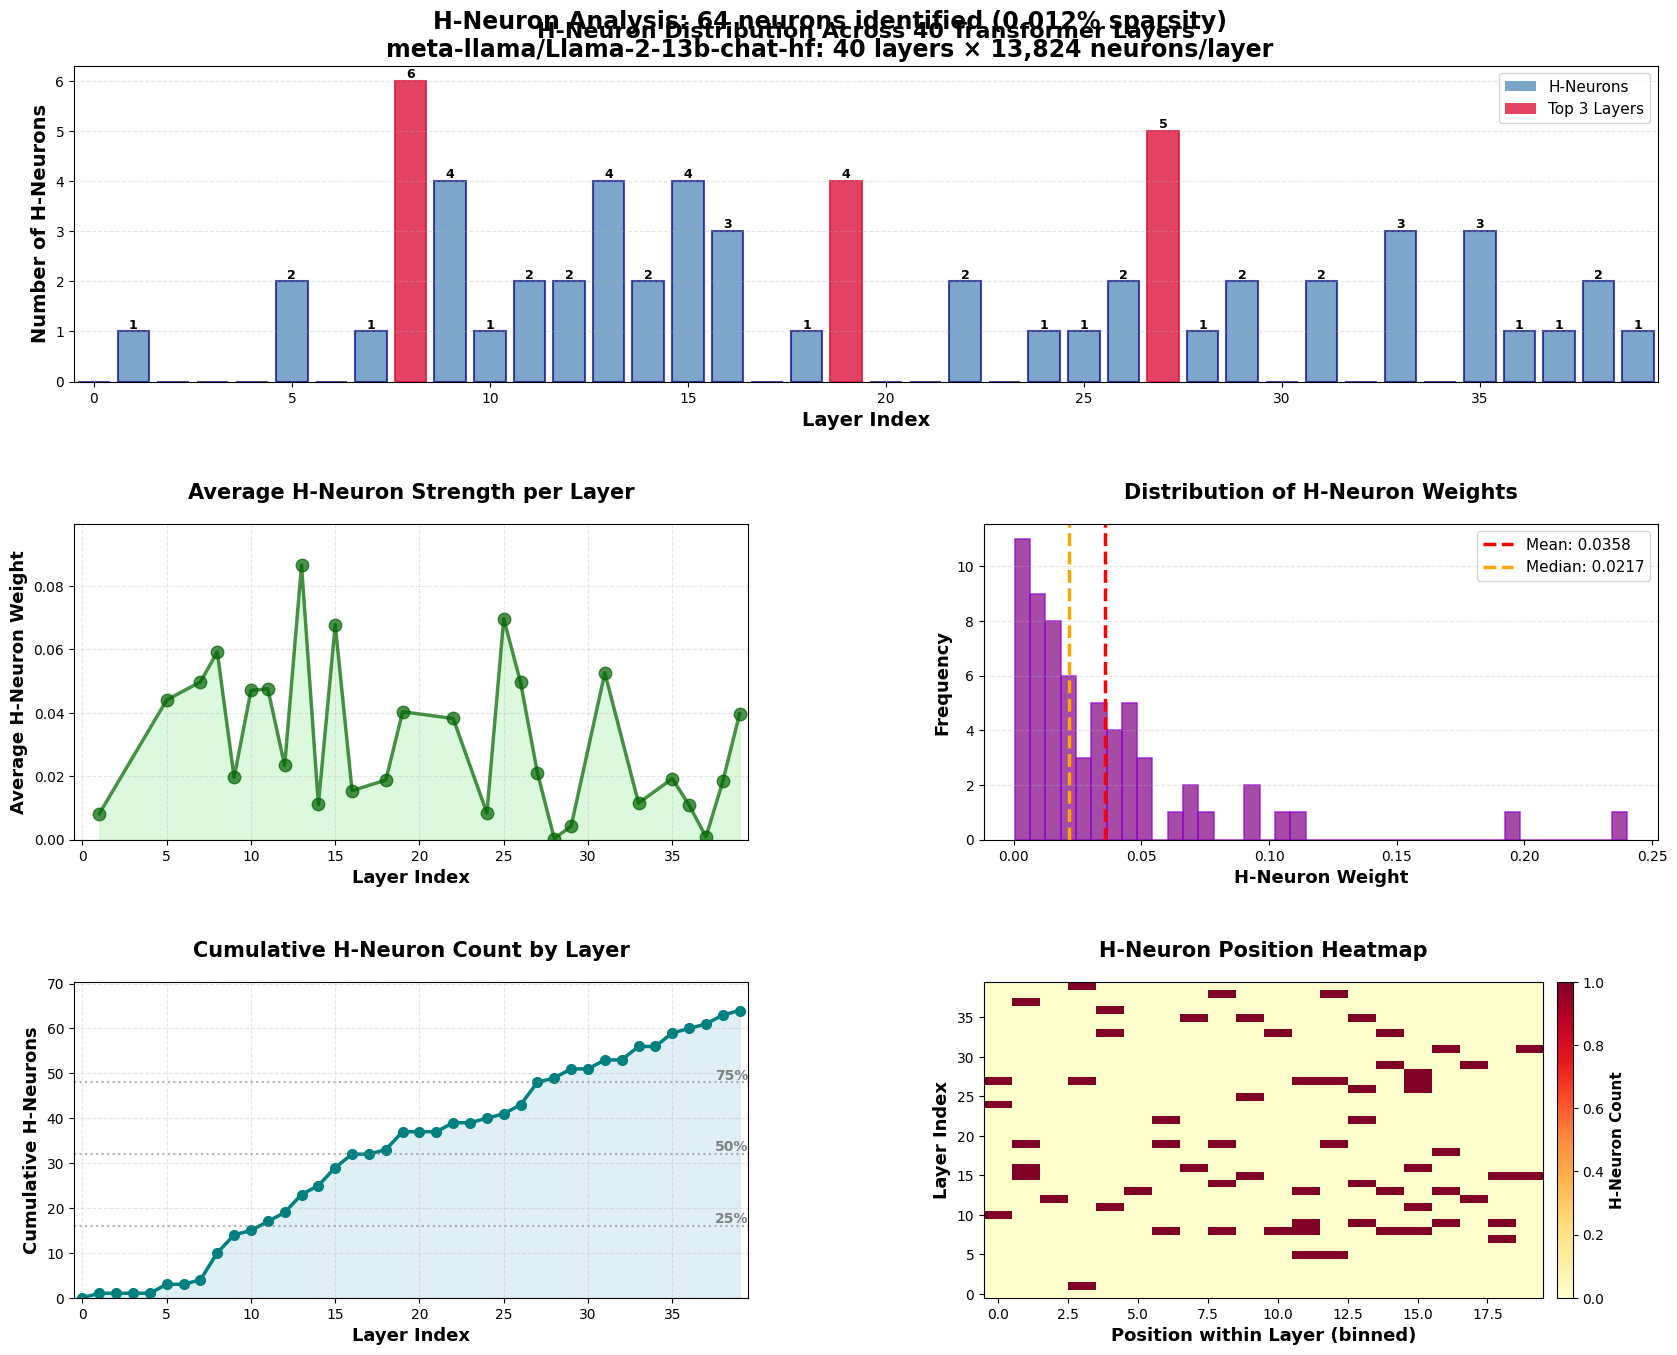


📊 DETAILED LAYER-WISE ANALYSIS:

  Architecture:
    Model: meta-llama/Llama-2-13b-chat-hf
    Total layers: 40
    Neurons per layer: 13,824
    Total neurons: 552,960

  H-Neuron Distribution:
    Total H-Neurons: 64
    Sparsity: 0.0116%
    Layers with H-Neurons: 28 / 40
    Min H-Neurons per layer: 0
    Max H-Neurons per layer: 6
    Mean H-Neurons per layer: 1.60
    Std H-Neurons per layer: 1.55

  Top 10 Layers by H-Neuron Count:
  Rank   Layer   H-Neurons    % of Total   Avg Weight  
  ------------------------------------------------------------
  1      8       6            9.4        % 0.059167
  2      27      5            7.8        % 0.021059
  3      19      4            6.2        % 0.040339
  4      15      4            6.2        % 0.067805
  5      13      4            6.2        % 0.086600
  6      9       4            6.2        % 0.019649
  7      35      3            4.7        % 0.019239
  8      33      3            4.7        % 0.011559
  9      16      3   

In [81]:
# Cell 7: Visualize H-Neuron Distribution with Correct Architecture

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print("\n" + "="*60)
print("CREATING H-NEURON VISUALIZATIONS")
print("="*60)

if len(h_neuron_indices) == 0:
    print("\n⚠️  No H-Neurons to visualize (0 neurons identified)")
else:
    
    print(f"\n📊 Using model architecture:")
    print(f"  Layers: {model_num_layers}")
    print(f"  Neurons per layer: {model_intermediate_size:,}")
    print(f"  Total neurons: {model_total_neurons:,}")
    
    # H-Neurons already calculated in Cell 4
    # h_neuron_layers = h_neuron_indices // model_intermediate_size
    # h_neuron_positions = h_neuron_indices % model_intermediate_size
    
    # Count H-Neurons per layer
    h_neurons_per_layer = np.zeros(model_num_layers, dtype=int)
    for layer_id in range(model_num_layers):
        h_neurons_per_layer[layer_id] = np.sum(h_neuron_layers == layer_id)
    
    # Average weight per layer
    avg_weight_per_layer = np.zeros(model_num_layers)
    for layer_id in range(model_num_layers):
        layer_mask = (h_neuron_layers == layer_id)
        if np.sum(layer_mask) > 0:
            avg_weight_per_layer[layer_id] = h_neuron_weights[layer_mask].mean()
    
    print(f"\n✅ Layer assignments:")
    print(f"  Layers with H-Neurons: {np.sum(h_neurons_per_layer > 0)}/{model_num_layers}")
    print(f"  H-Neuron layer range: {h_neuron_layers.min()}-{h_neuron_layers.max()}")
    
    # ==================== Create Visualization ====================
    print(f"\n🎨 Creating visualization...")
    
    fig = plt.figure(figsize=(18, 14))
    
    gs = fig.add_gridspec(3, 2, 
                         hspace=0.45,
                         wspace=0.35,
                         top=0.94,
                         bottom=0.06,
                         left=0.08,
                         right=0.96)
    
    # ========== Plot 1: H-Neurons per Layer ==========
    ax1 = fig.add_subplot(gs[0, :])
    
    bars = ax1.bar(range(model_num_layers), h_neurons_per_layer, 
                   color='steelblue', alpha=0.7, edgecolor='navy', linewidth=1.5)
    
    # Highlight top 3 layers
    if np.sum(h_neurons_per_layer > 0) >= 3:
        top_3_layers = np.argsort(h_neurons_per_layer)[-3:]
        for idx in top_3_layers:
            if h_neurons_per_layer[idx] > 0:
                bars[idx].set_color('crimson')
                bars[idx].set_alpha(0.8)
    
    ax1.set_xlabel('Layer Index', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of H-Neurons', fontsize=14, fontweight='bold')
    ax1.set_title(f'H-Neuron Distribution Across {model_num_layers} Transformer Layers', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax1.set_xlim(-0.5, model_num_layers-0.5)
    
    # Value labels
    for i, v in enumerate(h_neurons_per_layer):
        if v > 0:
            ax1.text(i, v, str(v), ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', alpha=0.7, label='H-Neurons'),
        Patch(facecolor='crimson', alpha=0.8, label='Top 3 Layers')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=11)
    
    # ========== Plot 2: Average Weight per Layer ==========
    ax2 = fig.add_subplot(gs[1, 0])
    
    layers_with_hneurons = np.where(h_neurons_per_layer > 0)[0]
    weights_to_plot = avg_weight_per_layer[layers_with_hneurons]
    
    if len(layers_with_hneurons) > 0:
        ax2.plot(layers_with_hneurons, weights_to_plot, 'o-', 
                 color='darkgreen', linewidth=2.5, markersize=9, alpha=0.7)
        ax2.fill_between(layers_with_hneurons, 0, weights_to_plot, 
                          color='lightgreen', alpha=0.3)
        
        y_max = weights_to_plot.max()
        ax2.set_ylim(0, y_max * 1.15)
    
    ax2.set_xlabel('Layer Index', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Average H-Neuron Weight', fontsize=13, fontweight='bold')
    ax2.set_title('Average H-Neuron Strength per Layer', 
                  fontsize=15, fontweight='bold', pad=18)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlim(-0.5, model_num_layers-0.5)
    
    # ========== Plot 3: Weight Distribution ==========
    ax3 = fig.add_subplot(gs[1, 1])
    
    ax3.hist(h_neuron_weights, bins=40, color='purple', alpha=0.7, 
             edgecolor='darkviolet', linewidth=1.2)
    
    mean_weight = h_neuron_weights.mean()
    median_weight = np.median(h_neuron_weights)
    
    ax3.axvline(mean_weight, color='red', linestyle='--', 
                linewidth=2.5, label=f'Mean: {mean_weight:.4f}')
    ax3.axvline(median_weight, color='orange', linestyle='--', 
                linewidth=2.5, label=f'Median: {median_weight:.4f}')
    
    ax3.set_xlabel('H-Neuron Weight', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=13, fontweight='bold')
    ax3.set_title('Distribution of H-Neuron Weights', 
                  fontsize=15, fontweight='bold', pad=18)
    ax3.legend(fontsize=11, loc='upper right')
    ax3.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    # ========== Plot 4: Cumulative H-Neurons ==========
    ax4 = fig.add_subplot(gs[2, 0])
    
    cumulative_hneurons = np.cumsum(h_neurons_per_layer)
    
    ax4.plot(range(model_num_layers), cumulative_hneurons, 'o-', 
             color='teal', linewidth=2.5, markersize=7)
    ax4.fill_between(range(model_num_layers), 0, cumulative_hneurons, 
                      color='lightblue', alpha=0.4)
    
    # Milestone lines
    total_h = len(h_neuron_indices)
    for pct in [25, 50, 75]:
        milestone = total_h * pct / 100
        ax4.axhline(milestone, color='gray', linestyle=':', alpha=0.6, linewidth=1.5)
        ax4.text(model_num_layers-0.5, milestone, f'{pct}%', 
                va='bottom', ha='right', fontsize=10, color='gray', fontweight='bold')
    
    ax4.set_xlabel('Layer Index', fontsize=13, fontweight='bold')
    ax4.set_ylabel('Cumulative H-Neurons', fontsize=13, fontweight='bold')
    ax4.set_title('Cumulative H-Neuron Count by Layer', 
                  fontsize=15, fontweight='bold', pad=18)
    ax4.grid(True, alpha=0.3, linestyle='--')
    ax4.set_xlim(-0.5, model_num_layers-0.5)
    ax4.set_ylim(0, total_h * 1.1)
    
    # ========== Plot 5: Position Heatmap ==========
    ax5 = fig.add_subplot(gs[2, 1])
    
    heatmap_data = np.zeros((model_num_layers, 20))
    
    for layer_id in range(model_num_layers):
        layer_mask = (h_neuron_layers == layer_id)
        if np.sum(layer_mask) > 0:
            positions = h_neuron_positions[layer_mask]
            bins = np.linspace(0, model_intermediate_size, 21)
            hist, _ = np.histogram(positions, bins=bins)
            heatmap_data[layer_id, :] = hist
    
    im = ax5.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', 
                    interpolation='nearest', origin='lower')
    
    ax5.set_xlabel('Position within Layer (binned)', fontsize=13, fontweight='bold')
    ax5.set_ylabel('Layer Index', fontsize=13, fontweight='bold')
    ax5.set_title('H-Neuron Position Heatmap', 
                  fontsize=15, fontweight='bold', pad=18)
    
    cbar = plt.colorbar(im, ax=ax5, pad=0.02)
    cbar.set_label('H-Neuron Count', fontsize=11, fontweight='bold')
    
    yticks = range(0, model_num_layers, max(1, model_num_layers//8))
    ax5.set_yticks(yticks)
    ax5.set_yticklabels([str(i) for i in yticks])
    
    # Overall title
    fig.suptitle(f'H-Neuron Analysis: {len(h_neuron_indices):,} neurons identified '
                f'({len(h_neuron_indices)/model_total_neurons*100:.3f}% sparsity)\n'
                f'{model.config._name_or_path}: {model_num_layers} layers × {model_intermediate_size:,} neurons/layer',
                fontsize=17, fontweight='bold', y=0.98)
    
    # Save
    output_dir = Path(CONFIG['output_path']).parent
    plot_path = output_dir / 'h_neurons_visualization.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight', 
                facecolor='white', pad_inches=0.3)
    
    print(f"\n✅ Visualization saved to: {plot_path}")
    
    plt.show()
    
    # ==================== Detailed Summary Statistics ====================
    print(f"\n📊 DETAILED LAYER-WISE ANALYSIS:")
    print(f"\n  Architecture:")
    print(f"    Model: {model.config._name_or_path}")
    print(f"    Total layers: {model_num_layers}")
    print(f"    Neurons per layer: {model_intermediate_size:,}")
    print(f"    Total neurons: {model_total_neurons:,}")
    
    print(f"\n  H-Neuron Distribution:")
    print(f"    Total H-Neurons: {len(h_neuron_indices):,}")
    print(f"    Sparsity: {len(h_neuron_indices)/model_total_neurons*100:.4f}%")
    print(f"    Layers with H-Neurons: {np.sum(h_neurons_per_layer > 0)} / {model_num_layers}")
    print(f"    Min H-Neurons per layer: {h_neurons_per_layer.min()}")
    print(f"    Max H-Neurons per layer: {h_neurons_per_layer.max()}")
    print(f"    Mean H-Neurons per layer: {h_neurons_per_layer.mean():.2f}")
    print(f"    Std H-Neurons per layer: {h_neurons_per_layer.std():.2f}")
    
    print(f"\n  Top 10 Layers by H-Neuron Count:")
    print(f"  {'Rank':<6} {'Layer':<7} {'H-Neurons':<12} {'% of Total':<12} {'Avg Weight':<12}")
    print(f"  {'-'*60}")
    
    top_10_layers = np.argsort(h_neurons_per_layer)[-10:][::-1]
    for rank, layer_id in enumerate(top_10_layers, 1):
        count = h_neurons_per_layer[layer_id]
        pct = (count / len(h_neuron_indices)) * 100 if count > 0 else 0
        avg_weight = avg_weight_per_layer[layer_id]
        print(f"  {rank:<6} {layer_id:<7} {count:<12} {pct:<11.1f}% {avg_weight:.6f}")
    
    print(f"\n  Weight Statistics (All H-Neurons):")
    print(f"    Min:    {h_neuron_weights.min():.6f}")
    print(f"    Max:    {h_neuron_weights.max():.6f}")
    print(f"    Mean:   {h_neuron_weights.mean():.6f}")
    print(f"    Median: {np.median(h_neuron_weights):.6f}")
    print(f"    Std:    {h_neuron_weights.std():.6f}")
    
    q1, q2, q3 = np.percentile(h_neuron_weights, [25, 50, 75])
    print(f"\n  Weight Quartiles:")
    print(f"    25th percentile: {q1:.6f}")
    print(f"    50th percentile: {q2:.6f}")
    print(f"    75th percentile: {q3:.6f}")
    
    # Network depth distribution
    early_layers = h_neurons_per_layer[:model_num_layers//3].sum()
    middle_layers = h_neurons_per_layer[model_num_layers//3:2*model_num_layers//3].sum()
    late_layers = h_neurons_per_layer[2*model_num_layers//3:].sum()
    
    print(f"\n  Distribution by Network Depth:")
    print(f"    Early layers (0-{model_num_layers//3-1}): "
          f"{early_layers:4d} H-Neurons ({early_layers/len(h_neuron_indices)*100:.1f}%)")
    print(f"    Middle layers ({model_num_layers//3}-{2*model_num_layers//3-1}): "
          f"{middle_layers:4d} H-Neurons ({middle_layers/len(h_neuron_indices)*100:.1f}%)")
    print(f"    Late layers ({2*model_num_layers//3}-{model_num_layers-1}): "
          f"{late_layers:4d} H-Neurons ({late_layers/len(h_neuron_indices)*100:.1f}%)")

print("="*60)


CREATING PUBLICATION-QUALITY H-NEURON HEATMAP

📊 Preparing heatmap data...
  Total neurons: 552,960
  H-Neurons: 64
  Layers: 40
  Neurons per layer: 13,824
  Binned matrix shape: (40, 100)
  Non-zero cells: 64

✅ Heatmap saved to: /workspace/h_neurons/h_neurons_heatmap.png
✅ High-res version saved to: /workspace/h_neurons/h_neurons_heatmap_highres.png


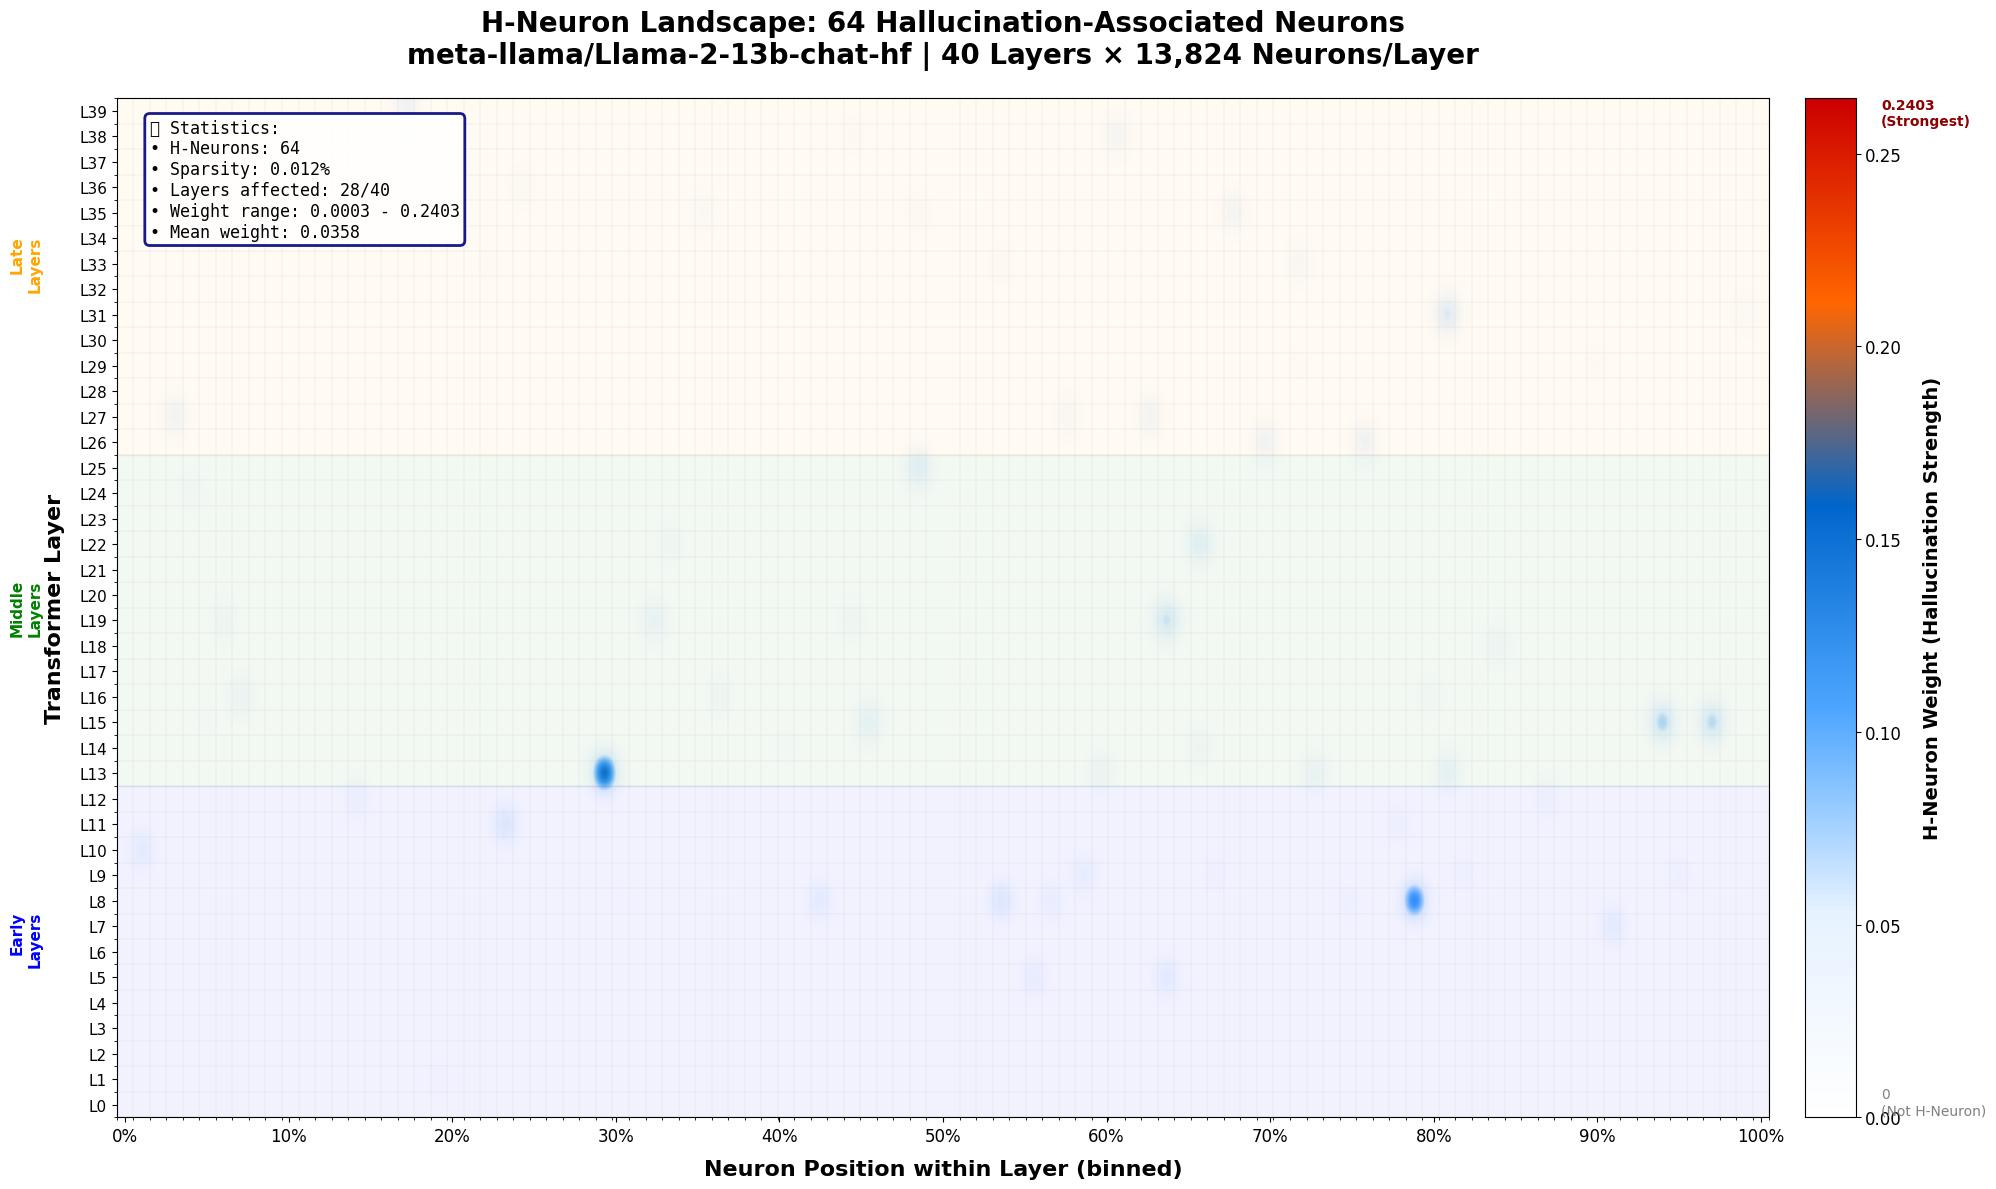


HEATMAP INTERPRETATION GUIDE

🎨 Color Coding:
  • White:      No H-Neuron (weight = 0)
  • Light Blue: Weak H-Neuron (low weight)
  • Blue:       Moderate H-Neuron
  • Orange:     Strong H-Neuron
  • Red:        Very Strong H-Neuron (high weight)

📍 What to Look For:
  • Horizontal bands: Layers with many H-Neurons
  • Vertical streaks: Specific neuron positions across layers
  • Hot spots (red): The strongest hallucination drivers
  • Clustering: Do H-Neurons group together?

🔬 Key Findings:
  • Early layers (0-12): 19 H-Neurons (29.7%)
  • Middle layers (13-25): 22 H-Neurons (34.4%)
  • Late layers (26-39): 23 H-Neurons (35.9%)

  💡 Insight: H-Neurons concentrated in LATE layers
     → Hallucinations may form during final processing stages

  💡 Insight: H-Neurons spread across neuron positions
     → Hallucination neurons don't follow positional pattern


In [82]:
# Cell 8: Beautiful Heatmap - H-Neuron Location and Strength

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap

print("\n" + "="*60)
print("CREATING PUBLICATION-QUALITY H-NEURON HEATMAP")
print("="*60)

if len(h_neuron_indices) == 0:
    print("\n⚠️  No H-Neurons to visualize")
else:
    
    print(f"\n📊 Preparing heatmap data...")
    print(f"  Total neurons: {model_total_neurons:,}")
    print(f"  H-Neurons: {len(h_neuron_indices):,}")
    print(f"  Layers: {model_num_layers}")
    print(f"  Neurons per layer: {model_intermediate_size:,}")
    
    # ==================== Create Heatmap Matrix ====================
    # Matrix dimensions: [num_layers, neurons_per_layer]
    # Value: H-Neuron weight (0 if not an H-Neuron)
    
    heatmap_matrix = np.zeros((model_num_layers, model_intermediate_size))
    
    # Fill in H-Neuron weights
    for i, neuron_idx in enumerate(h_neuron_indices):
        layer = neuron_idx // model_intermediate_size
        position = neuron_idx % model_intermediate_size
        weight = h_neuron_weights[i]
        heatmap_matrix[layer, position] = weight
    
    # For visualization, we'll bin the positions (too many to show individually)
    n_bins = 100  # Bin neurons into 100 columns for cleaner visualization
    binned_matrix = np.zeros((model_num_layers, n_bins))
    
    bin_size = model_intermediate_size // n_bins
    
    for layer in range(model_num_layers):
        for bin_idx in range(n_bins):
            start_pos = bin_idx * bin_size
            end_pos = min(start_pos + bin_size, model_intermediate_size)
            # Take max weight in this bin (to highlight strong H-Neurons)
            binned_matrix[layer, bin_idx] = heatmap_matrix[layer, start_pos:end_pos].max()
    
    print(f"  Binned matrix shape: {binned_matrix.shape}")
    print(f"  Non-zero cells: {np.sum(binned_matrix > 0)}")
    
    # ==================== Create Beautiful Heatmap ====================
    
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Custom colormap: White → Light Blue → Blue → Red
    colors = ['#ffffff', '#e6f2ff', '#4da6ff', '#0066cc', '#ff6600', '#cc0000']
    n_bins_cmap = 256
    cmap = LinearSegmentedColormap.from_list('h_neurons', colors, N=n_bins_cmap)
    
    # Create heatmap
    im = ax.imshow(binned_matrix, 
                   aspect='auto', 
                   cmap=cmap,
                   interpolation='gaussian',  # Smooth interpolation
                   origin='lower',
                   vmin=0,
                   vmax=h_neuron_weights.max() * 1.1)  # Scale for better contrast
    
    # ==================== Styling ====================
    
    # Title
    ax.set_title(f'H-Neuron Landscape: {len(h_neuron_indices):,} Hallucination-Associated Neurons\n'
                 f'{model.config._name_or_path} | {model_num_layers} Layers × {model_intermediate_size:,} Neurons/Layer',
                 fontsize=20, fontweight='bold', pad=25)
    
    # Axes labels
    ax.set_xlabel('Neuron Position within Layer (binned)', 
                  fontsize=16, fontweight='bold', labelpad=10)
    ax.set_ylabel('Transformer Layer', 
                  fontsize=16, fontweight='bold', labelpad=10)
    
    # Y-axis: show every layer
    ax.set_yticks(range(model_num_layers))
    ax.set_yticklabels([f'L{i}' for i in range(model_num_layers)], fontsize=11)
    
    # X-axis: show bin positions
    x_tick_positions = np.linspace(0, n_bins-1, 11)  # 11 ticks (0%, 10%, ..., 100%)
    x_tick_labels = [f'{int(i*10)}%' for i in range(11)]
    ax.set_xticks(x_tick_positions)
    ax.set_xticklabels(x_tick_labels, fontsize=12)
    
    # Grid
    ax.set_xticks(np.arange(-.5, n_bins, 1), minor=True)
    ax.set_yticks(np.arange(-.5, model_num_layers, 1), minor=True)
    ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.3, alpha=0.2)
    
    # ==================== Colorbar ====================
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.set_label('H-Neuron Weight (Hallucination Strength)', 
                   fontsize=14, fontweight='bold', labelpad=15)
    cbar.ax.tick_params(labelsize=12)
    
    # Add colorbar annotations
    cbar.ax.text(1.5, 0, '0\n(Not H-Neuron)', 
                 transform=cbar.ax.transAxes, 
                 fontsize=10, va='bottom', ha='left', color='gray')
    cbar.ax.text(1.5, 1, f'{h_neuron_weights.max():.4f}\n(Strongest)', 
                 transform=cbar.ax.transAxes, 
                 fontsize=10, va='top', ha='left', color='darkred', fontweight='bold')
    
    # ==================== Add Layer Statistics Annotations ====================
    
    # Count H-Neurons per layer
    h_neurons_per_layer = np.zeros(model_num_layers, dtype=int)
    for layer_id in range(model_num_layers):
        h_neurons_per_layer[layer_id] = np.sum(h_neuron_layers == layer_id)
    
    # Find top 5 layers
    top_5_layers = np.argsort(h_neurons_per_layer)[-5:][::-1]
    
    # Annotate top layers on the right side
    for rank, layer_id in enumerate(top_5_layers):
        count = h_neurons_per_layer[layer_id]
        if count > 0:
            # Add arrow pointing to layer
            ax.annotate(f'{count} H-Neurons', 
                       xy=(n_bins, layer_id), 
                       xytext=(n_bins + 15, layer_id),
                       fontsize=11, 
                       fontweight='bold',
                       color='darkred' if rank == 0 else 'orangered',
                       ha='left',
                       va='center',
                       bbox=dict(boxstyle='round,pad=0.5', 
                                facecolor='yellow' if rank == 0 else 'lightyellow', 
                                alpha=0.8, 
                                edgecolor='darkred' if rank == 0 else 'orange'),
                       arrowprops=dict(arrowstyle='->', 
                                     color='darkred' if rank == 0 else 'orange',
                                     lw=2))
    
    # ==================== Add Summary Statistics Box ====================
    
    # Calculate statistics
    total_h = len(h_neuron_indices)
    sparsity = (total_h / model_total_neurons) * 100
    layers_affected = np.sum(h_neurons_per_layer > 0)
    
    # Statistics text box
    stats_text = f'📊 Statistics:\n'
    stats_text += f'• H-Neurons: {total_h:,}\n'
    stats_text += f'• Sparsity: {sparsity:.3f}%\n'
    stats_text += f'• Layers affected: {layers_affected}/{model_num_layers}\n'
    stats_text += f'• Weight range: {h_neuron_weights.min():.4f} - {h_neuron_weights.max():.4f}\n'
    stats_text += f'• Mean weight: {h_neuron_weights.mean():.4f}'
    
    # Add text box in top-left
    ax.text(0.02, 0.98, stats_text,
           transform=ax.transAxes,
           fontsize=12,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='navy', linewidth=2),
           family='monospace')
    
    # ==================== Add Network Depth Zones ====================
    
    # Divide into early/middle/late layers
    early_end = model_num_layers // 3
    middle_end = 2 * model_num_layers // 3
    
    # Add subtle background shading
    ax.axhspan(-0.5, early_end - 0.5, alpha=0.05, color='blue', zorder=0)
    ax.axhspan(early_end - 0.5, middle_end - 0.5, alpha=0.05, color='green', zorder=0)
    ax.axhspan(middle_end - 0.5, model_num_layers - 0.5, alpha=0.05, color='orange', zorder=0)
    
    # Add labels for depth zones
    ax.text(-5, early_end/2, 'Early\nLayers', 
           fontsize=11, fontweight='bold', color='blue', 
           ha='right', va='center', rotation=90)
    ax.text(-5, early_end + (middle_end - early_end)/2, 'Middle\nLayers', 
           fontsize=11, fontweight='bold', color='green', 
           ha='right', va='center', rotation=90)
    ax.text(-5, middle_end + (model_num_layers - middle_end)/2, 'Late\nLayers', 
           fontsize=11, fontweight='bold', color='orange', 
           ha='right', va='center', rotation=90)
    
    # ==================== Save Figure ====================
    
    plt.tight_layout()
    
    output_dir = Path(CONFIG['output_path']).parent
    heatmap_path = output_dir / 'h_neurons_heatmap.png'
    
    plt.savefig(heatmap_path, dpi=300, bbox_inches='tight', 
                facecolor='white', pad_inches=0.4)
    
    print(f"\n✅ Heatmap saved to: {heatmap_path}")
    
    # Also save high-res version for publications
    heatmap_highres_path = output_dir / 'h_neurons_heatmap_highres.png'
    plt.savefig(heatmap_highres_path, dpi=600, bbox_inches='tight', 
                facecolor='white', pad_inches=0.4)
    
    print(f"✅ High-res version saved to: {heatmap_highres_path}")
    
    plt.show()
    
    # ==================== Print Interpretation Guide ====================
    
    print(f"\n" + "="*60)
    print("HEATMAP INTERPRETATION GUIDE")
    print("="*60)
    
    print(f"\n🎨 Color Coding:")
    print(f"  • White:      No H-Neuron (weight = 0)")
    print(f"  • Light Blue: Weak H-Neuron (low weight)")
    print(f"  • Blue:       Moderate H-Neuron")
    print(f"  • Orange:     Strong H-Neuron")
    print(f"  • Red:        Very Strong H-Neuron (high weight)")
    
    print(f"\n📍 What to Look For:")
    print(f"  • Horizontal bands: Layers with many H-Neurons")
    print(f"  • Vertical streaks: Specific neuron positions across layers")
    print(f"  • Hot spots (red): The strongest hallucination drivers")
    print(f"  • Clustering: Do H-Neurons group together?")
    
    print(f"\n🔬 Key Findings:")
    
    # Analyze distribution
    early_h = np.sum(h_neurons_per_layer[:early_end])
    middle_h = np.sum(h_neurons_per_layer[early_end:middle_end])
    late_h = np.sum(h_neurons_per_layer[middle_end:])
    
    print(f"  • Early layers (0-{early_end-1}): {early_h} H-Neurons ({early_h/total_h*100:.1f}%)")
    print(f"  • Middle layers ({early_end}-{middle_end-1}): {middle_h} H-Neurons ({middle_h/total_h*100:.1f}%)")
    print(f"  • Late layers ({middle_end}-{model_num_layers-1}): {late_h} H-Neurons ({late_h/total_h*100:.1f}%)")
    
    if late_h > early_h and late_h > middle_h:
        print(f"\n  💡 Insight: H-Neurons concentrated in LATE layers")
        print(f"     → Hallucinations may form during final processing stages")
    elif middle_h > early_h and middle_h > late_h:
        print(f"\n  💡 Insight: H-Neurons concentrated in MIDDLE layers")
        print(f"     → Hallucinations may form during intermediate representations")
    elif early_h > middle_h and early_h > late_h:
        print(f"\n  💡 Insight: H-Neurons concentrated in EARLY layers")
        print(f"     → Hallucinations may form from initial processing")
    else:
        print(f"\n  💡 Insight: H-Neurons evenly distributed across depth")
        print(f"     → Hallucination formation is a multi-stage process")
    
    # Check for positional clustering
    position_variance = np.var([h_neuron_positions])
    max_possible_variance = (model_intermediate_size ** 2) / 12  # Variance of uniform distribution
    
    if position_variance < 0.5 * max_possible_variance:
        print(f"\n  💡 Insight: H-Neurons cluster in specific positions")
        print(f"     → Certain neuron positions may be more prone to hallucinations")
    else:
        print(f"\n  💡 Insight: H-Neurons spread across neuron positions")
        print(f"     → Hallucination neurons don't follow positional pattern")
    
    print("="*60)

print("="*60)